In [ ]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
from scipy import stats
from ast import literal_eval
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
import math

# SET PATH
PATH = "../data"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Frequency Matrices

In [ ]:
freq_matrix_cats = pd.read_csv(f"{PATH}/freq_matrix_cats.csv", index_col = 0)
freq_matrix_names = pd.read_csv(f"{PATH}/freq_matrix_names.csv", index_col = 0)

In [ ]:
print(len(freq_matrix_cats))
print(len(freq_matrix_names))

255093
270320


# Logistic Regression

In [ ]:
def make_regression_df(_freq_matrix_CATEGORIES, _freq_matrix_NAMES, intersection, criteria, THRESHOLD):
  '''Function to split dataframe by intersection, with base category always included so it can be used in the regression'''
  # Subset dataframe
  if intersection == 'continent':
    subset_df = _freq_matrix_NAMES
  else:
    if intersection == 'religion':
      subs = ['base', 'christian', 'buddhist', 'hindu', 'jewish', 'muslim', 'sikh']
    elif intersection == 'ethnicity':
      subs = ['base', 'asian', 'black', 'hispanic', 'white']
    elif intersection == 'sexuality':
      subs = ['base', 'gay', 'straight']
    elif intersection == 'political':
      subs = ['base', 'conservative', 'liberal']
    elif intersection == 'base':
      subs = ['base']
    subset_df = _freq_matrix_CATEGORIES[_freq_matrix_CATEGORIES['category'].isin(subs)]
  df_frequency = subset_df.groupby(['category', 'gender']).aggregate(sum).astype(int)
  thresholds = df_frequency.copy()
  # Apply threshold
  for token in df_frequency.columns:
    if df_frequency[token].aggregate(sum) < THRESHOLD:
      thresholds = thresholds.drop(columns = token)
  proportions = thresholds.div(thresholds.aggregate(sum))
  # Selection criteria
  if criteria == 'range':
    selection = proportions.aggregate(max) - proportions.aggregate(min)
  if criteria == 'std':
    selection = proportions.aggregate(np.std)
  selection = selection.sort_values(ascending = False)
  # Keep all jobs or subset by list
  keep_jobs = list(selection.index)
  keep_jobs.extend(['gender', 'category'])
  reg_df = subset_df[keep_jobs]
  # Replace spaces
  for token in reg_df.columns:
    if ' ' in token:                                                              
      old_token = token
      token = old_token.replace(" ", "_")
      reg_df = reg_df.rename(columns = {old_token : token})
    # Replace hyphens
    if '-' in token:                                                              
      old_token = token
      token = old_token.replace("-", "_")
      reg_df = reg_df.rename(columns = {old_token : token})
  return reg_df

## Regression Run Code

In [ ]:
def run_regression_main_effects(input_df, token, leave_out_cat, leave_out_gend):
  ''' Function to run regression main effects (no intersections) for ONE JOB and return model output'''
  df = input_df[['category', 'gender', token]]
  df = df.rename(columns = {'category': '**', 'gender': 'gender'})
  df = pd.get_dummies(df, columns = ['**', 'gender'])
  df.columns = df.columns.str.lstrip('**_')
  df = df.rename(columns = {'gender_F': 'female', 'gender_M': 'male'})
  df = df.drop(columns = [leave_out_cat, leave_out_gend])
  X = df.loc[:, df.columns != token]
  y = df.loc[:, df.columns == token][token]
  y_columns = [y.name]
  X_columns = list(X.columns.values)
  print(f"""
  y_columns: {y_columns}
  X_columns: {X_columns}\n""")
  # METHOD: statsmodels.formula.api.logit
  main_effects = list(X.columns.values)
  all_regression_terms = f"{' + '.join(main_effects)}"
  print(all_regression_terms)
  logit_model = smf.logit(formula = f"{token} ~ {all_regression_terms}", data = df)
  try:
    est = logit_model.fit()
    print(f"\n> Logistic Regression {est.summary2()}")
    print("\n====================================================================\n\n\n")
    return est, main_effects, token
  except:
    print("\n\n******CANNOT FIT MODEL*******\n\n")
    pass

In [ ]:
def run_regression_interaction(input_df, token, leave_out_cat, leave_out_gend):
  ''' Function to run regression main effects with intersections for ONE JOB and return model output'''
  df = input_df[['category', 'gender', token]]
  df = df.rename(columns = {'category': '**', 'gender': 'gender'})
  df = pd.get_dummies(df, columns = ['**', 'gender'])
  df.columns = df.columns.str.lstrip('**_')
  df = df.rename(columns = {'gender_F': 'female', 'gender_M': 'male'})
  df = df.drop(columns = [leave_out_cat, leave_out_gend])
  X = df.loc[:, df.columns != token]
  y = df.loc[:, df.columns == token][token]
  y_columns = [y.name]
  X_columns = list(X.columns.values)
  print(f"""
  y_columns: {y_columns}
  X_columns: {X_columns}\n""")
  # METHOD: statsmodels.formula.api.logit
  main_effects = list(X.columns.values)
  interaction_terms = [list(X.columns.values)[-1] + ':' + cont for cont in list(X.columns.values)[:-1]]
  all_regression_terms = f"{' + '.join(main_effects)}" + " + " + f"{' + '.join(interaction_terms)}"
  logit_model = smf.logit(formula = f"{token} ~ {all_regression_terms}", data = df)
  try:
    est = logit_model.fit()
    print(f"\n> Logistic Regression {est.summary2()}")
    print("\n====================================================================\n\n\n")
    return est, main_effects, interaction_terms, token
  except:
    print("\n\n******CANNOT FIT MODEL*******\n\n")
    pass

In [ ]:
def run_regression_no_female(input_df, token, leave_out_cats = 'base', leave_out_genders = ['male', 'female']):
  ''' Function to run regression main effects without woman dummy for ONE JOB and return model output'''
  df = input_df[['category', 'gender', token]]
  df = df.rename(columns = {'category': '**', 'gender': 'gender'})
  df = pd.get_dummies(df, columns = ['**', 'gender'])
  df.columns = df.columns.str.lstrip('**_')
  df = df.rename(columns = {'gender_F': 'female', 'gender_M': 'male'})
  drops = [leave_out_cats]
  drops.extend(leave_out_genders)
  df = df.drop(columns = drops)
  X = df.loc[:, df.columns != token]
  y = df.loc[:, df.columns == token][token]
  y_columns = [y.name]
  X_columns = list(X.columns.values)
  print(f"""
  y_columns: {y_columns}
  X_columns: {X_columns}\n""")
  # METHOD: statsmodels.formula.api.logit
  main_effects = list(X.columns.values)
  all_regression_terms = f"{' + '.join(main_effects)}"
  print(all_regression_terms)
  logit_model = smf.logit(formula = f"{token} ~ {all_regression_terms}", data = df)
  try:
    est = logit_model.fit()
    print(f"\n> Logistic Regression {est.summary2()}")
    print("\n====================================================================\n\n\n")
    return est, main_effects, token
  except:
    print("\n\n******CANNOT FIT MODEL*******\n\n")
    pass

In [ ]:
def initialize_regression(regression_df, regression_func = "main effects"):
  ''' Function to initialize regressions for ALL JOBS > THRESHOLD, with specified regression function
  Returns list of model results and list of professions'''
  leave_out_cat_list = ['base']
  leave_out_gend_list = ['male']
  models = []
  main_effects = []
  interactions = []
  models_professions = []
  i = 0
  jobs_list = list(regression_df.columns)
  jobs_list.remove('gender')
  jobs_list.remove('category')
  for TK in jobs_list:
    j = 0
    for LV_cat in leave_out_cat_list:
      for LV_gend in leave_out_gend_list:
        print(f"""
  _______________________________________   regression {i}.{j}
  _______________________________________   token: {TK}
  _______________________________________   leave_out_cat: {LV_cat}
  _______________________________________   leave_out_gend: {LV_gend}""")
      if regression_func == 'main effects':
        results = run_regression_main_effects(regression_df,token = TK, leave_out_cat = LV_cat, leave_out_gend = LV_gend)
        try:
          est, main_effects, token = results
          models.append(est)
          main_effects.append(main_effects)
          models_professions.append(token)
        except:
          print("\n\n******NO MODEL*******\n\n")
          pass
        j += 1
      if regression_func == 'no female':
        results = run_regression_no_female(regression_df,token = TK, leave_out_cats = 'base' ,leave_out_genders = ['male', 'female'])
        try:
          est, main_effects, token = results
          models.append(est)
          main_effects.append(main_effects)
          models_professions.append(token)
        except:
          print("\n\n******NO MODEL*******\n\n")
          pass
        j += 1
      if regression_func == 'interactions':
        results = run_regression_interaction(regression_df,token = TK, leave_out_cat = LV_cat, leave_out_gend = LV_gend)
        try:
          est, main_effects, interaction_terms,  token = results
          models.append(est)
          main_effects.append(main_effects)
          interactions.append(interaction_terms)
          models_professions.append(token)
        except:
          print("\n\n******NO MODEL*******\n\n")
          pass
        j += 1
    i += 1
  return models, models_professions

## Regression Metrics Code

In [ ]:
def regression_results(models, models_professions, models_gen, models_professions_gen, models_int, models_professions_int):
  ''' Function to return key regression metrics: coeffs, R2 and P-Values.
  Summaries across three regression hierarchies: 
  (i) main effect - woman dummy
  (ii) all main effects
  (iii) all main effects + interactions'''
  # R2
  R2_main_effects= {}
  R2_gender = {}
  R2_interactions = {}
  # Coeff
  coeff_main_effects = {}
  coeff_interactions = {}
  coeff_gender = {}
  # P-Values
  p_interactions = {}
  # Main Effects
  for i in range(len(models)):
    profession = models_professions[i]
    R2 = (models[i].prsquared*100)
    coeffs = models[i].params
    R2_main_effects[profession] = R2
    coeff_main_effects[profession] = coeffs
  # No Female
  for i in range(len(models_gen)):
    profession = models_professions_gen[i]
    R2 = (models_gen[i].prsquared*100)
    coeffs = models_gen[i].params
    R2_gender[profession] = R2
    coeff_gender[profession] = coeffs
  # Female + Interactions
  for i in range(len(models_int)):
    profession = models_professions_int[i]
    R2 = (models_int[i].prsquared*100)
    coeffs = models_int[i].params
    p_values = models_int[i].pvalues
    R2_interactions[profession] = R2
    coeff_interactions[profession] = coeffs
    p_interactions[profession] = p_values
  # Output Results
  #R2
  R2_main_df = pd.DataFrame.from_dict(R2_main_effects, orient = 'index', columns = {'R2_main'})
  R2_int_df = pd.DataFrame.from_dict(R2_interactions, orient = 'index',  columns = {'R2_int'})
  R2_gen_df = pd.DataFrame.from_dict(R2_gender, orient = 'index',  columns = {'R2_gen'})
  # Coeffs
  coeff_main_df = pd.DataFrame.from_dict(coeff_main_effects)
  coeff_int_df = pd.DataFrame.from_dict(coeff_interactions)
  coeff_gen_df = pd.DataFrame.from_dict(coeff_interactions)
  # P-Values
  pvalue_df = pd.DataFrame.from_dict(p_interactions)
  return R2_main_df, R2_int_df, R2_gen_df, coeff_main_df, coeff_int_df, coeff_gen_df, pvalue_df

In [ ]:
def count_signif_results(pvalue_df):
  ''' Function to return mean count and bool dataframe of signif p-values'''
  # Count P-Value < 0.05
  bool_pvalue_df = pvalue_df < 0.05
  mean = bool_pvalue_df.mean(axis = 1)
  # Count Negative, Positive
  return bool_pvalue_df, mean

In [ ]:
def return_results_tables(freq_matrix_cats, freq_matrix_names, intersection, criteria, THRESHOLD):
   ''' Function to run regressions and return regression results across three regression hierarchies: 
  (i) main effect - woman dummy
  (ii) all main effects
  (iii) all main effects + interactions'''
  regression_df = make_regression_df(freq_matrix_cats, freq_matrix_names, intersection, criteria, THRESHOLD)
  models, models_professions = initialize_regression(regression_df, 'main effects')
  models_int, models_professions_int = initialize_regression(regression_df, 'interactions')
  models_gen, models_professions_gen = initialize_regression(regression_df, 'no female')
  R2_main_df, R2_int_df, R2_gen_df, coeff_main_df, coeff_int_df, coeff_gen_df, pvalue_df = regression_results(models, models_professions,
                                                                                                              models_gen, models_professions_gen,
                                                                                                              models_int, models_professions_int)                                             
  # R2 Table
  merge_1 = R2_gen_df.merge(R2_main_df, left_index = True, right_index = True)
  merge_2 = merge_1.merge(R2_int_df, left_index = True, right_index = True)
  merge_2['R2_gen_change'] = merge_2['R2_main'] - merge_2['R2_gen']
  merge_2['R2_int_change'] = merge_2['R2_int'] - merge_2['R2_main']
  R2 = merge_2.copy()
  # P Values
  bool_pvalue_df, mean_signif = count_signif_results(pvalue_df)
  # Count Signif
  value_df = coeff_int_df.copy()
  # If coeff = insignificant sets equal to 0, otherwise keeps coefficient
  for j in bool_pvalue_df.columns:
    for i in bool_pvalue_df.index:
      signif = bool_pvalue_df.loc[i, j]
      if signif == True:
        value_df.loc[i,j] = coeff_int_df.loc[i,j]
      else:
        value_df.loc[i,j] = 0
  return R2, bool_pvalue_df, value_df, mean_signif

## Regression Results

### Ethnicity

In [ ]:
eth_R2, eth_pvalue_df, eth_value_df, eth_mean_signif = return_results_tables(freq_matrix_cats, freq_matrix_names, 'ethnicity', 'range', 140)


  _______________________________________   regression 0.0
  _______________________________________   token: guard
  _______________________________________   leave_out_cat: base
  _______________________________________   leave_out_gend: male

  y_columns: ['guard']
  X_columns: ['asian', 'black', 'hispanic', 'white', 'female']

asian + black + hispanic + white + female
Optimization terminated successfully.
         Current function value: 0.015439
         Iterations 13

> Logistic Regression                           Results: Logit
Model:              Logit            Pseudo R-squared: 0.166      
Dependent Variable: guard            AIC:              2668.3578  
Date:               2021-01-25 16:18 BIC:              2724.5323  
No. Observations:   86027            Log-Likelihood:   -1328.2    
Df Model:           5                LL-Null:          -1592.3    
Df Residuals:       86021            LLR p-value:      6.4505e-112
Converged:          1.0000           Scale:            

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35


******CANNOT FIT MODEL*******




******NO MODEL*******



  _______________________________________   regression 2.0
  _______________________________________   token: supervisor
  _______________________________________   leave_out_cat: base
  _______________________________________   leave_out_gend: male

  y_columns: ['supervisor']
  X_columns: ['asian', 'black', 'hispanic', 'white', 'female']

asian + black + hispanic + white + female
Optimization terminated successfully.
         Current function value: 0.014008
         Iterations 11

> Logistic Regression                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.048     
Dependent Variable: supervisor       AIC:              2422.2077 
Date:               2021-01-25 16:18 BIC:              2478.3822 
No. Observations:   86027            Log-Likelihood:   -1205.1   
Df Model:           5                LL-Null:          -1265.6 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.168     
Dependent Variable:   cashier            AIC:                2098.2278 
Date:                 2021-01-25 16:18   BIC:                2154.4023 
No. Observations:     86027              Log-Likelihood:     -1043.1   
Df Model:             5                  LL-Null:            -1253.2   
Df Residuals:         86021              LLR p-value:        1.3184e-88
Converged:            0.0000             Scale:              1.0000    
No. Iterations:       35.0000                                          
-----------------------------------------------------------------------
           Coef.     Std.Err.     z     P>|z|     [0.025       0.975]  
-----------------------------------------------------------------------
Intercept  -4.9631      0.1274 -38.9434 0.0000      -5.2129     -4.7133
asian     -12.3492     61.9855  -0.1992 0.8421    -133.8385    109.140

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                           Results: Logit
Model:              Logit            Pseudo R-squared: 0.126      
Dependent Variable: plumber          AIC:              3312.7939  
Date:               2021-01-25 16:19 BIC:              3368.9684  
No. Observations:   86027            Log-Likelihood:   -1650.4    
Df Model:           5                LL-Null:          -1889.0    
Df Residuals:       86021            LLR p-value:      6.6187e-101
Converged:          0.0000           Scale:            1.0000     
No. Iterations:     35.0000                                       
-------------------------------------------------------------------
             Coef.    Std.Err.     z      P>|z|    [0.025    0.975]
-------------------------------------------------------------------
Intercept    -4.7848    0.1167  -40.9896  0.0000   -5.0136  -4.5560
asian         0.0114    0.1662    0.0686  0.9453   -0.3144   0.3372
black        -0.0663    0.1700   -0.3900  0.6965   -0.3995  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                 Logit               Pseudo R-squared:    0.211     
Dependent Variable:    monk                AIC:                 1718.7915 
Date:                  2021-01-25 16:19    BIC:                 1812.4157 
No. Observations:      86027               Log-Likelihood:      -849.40   
Df Model:              9                   LL-Null:             -1077.2   
Df Residuals:          86017               LLR p-value:         1.8449e-92
Converged:             0.0000              Scale:               1.0000    
No. Iterations:        35.0000                                            
--------------------------------------------------------------------------
                 Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
--------------------------------------------------------------------------
Intercept        -4.8700     0.1217 -40.0060 0.0000     -5.1086    -4.6314
asian           -17.3206   710.5

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))



> Logistic Regression                                  Results: Logit
Model:                   Logit                  Pseudo R-squared:      0.130     
Dependent Variable:      massage_therapist      AIC:                   2189.0890 
Date:                    2021-01-25 16:19       BIC:                   2282.7131 
No. Observations:        86027                  Log-Likelihood:        -1084.5   
Df Model:                9                      LL-Null:               -1247.0   
Df Residuals:            86017                  LLR p-value:           1.3362e-64
Converged:               0.0000                 Scale:                 1.0000    
No. Iterations:          35.0000                                                 
---------------------------------------------------------------------------------
                 Coef.     Std.Err.      z    P>|z|      [0.025         0.975]   
---------------------------------------------------------------------------------
Intercept       -21.9017   

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                 Logit             Pseudo R-squared:  0.112      
Dependent Variable:    prostitute        AIC:               11629.0992 
Date:                  2021-01-25 16:19  BIC:               11722.7234 
No. Observations:      86027             Log-Likelihood:    -5804.5    
Df Model:              9                 LL-Null:           -6538.7    
Df Residuals:          86017             LLR p-value:       1.3419e-310
Converged:             0.0000            Scale:             1.0000     
No. Iterations:        35.0000                                         
-----------------------------------------------------------------------
                 Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------------
Intercept        -8.4038    0.7072 -11.8834 0.0000    -9.7899   -7.0177
asian             0.0387    1.0001   0.0387 0.9691    -1.9215    1.998

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                 Logit               Pseudo R-squared:    0.113     
Dependent Variable:    laborer             AIC:                 2675.8757 
Date:                  2021-01-25 16:19    BIC:                 2769.4999 
No. Observations:      86027               Log-Likelihood:      -1327.9   
Df Model:              9                   LL-Null:             -1497.0   
Df Residuals:          86017               LLR p-value:         2.1417e-67
Converged:             0.0000              Scale:               1.0000    
No. Iterations:        35.0000                                            
--------------------------------------------------------------------------
                 Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
--------------------------------------------------------------------------
Intercept        -4.9631     0.1274 -38.9434 0.0000     -5.2129    -4.7133
asian            -2.9964     0.5

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                 Results: Logit
Model:                   Logit                Pseudo R-squared:     0.087     
Dependent Variable:      caretaker            AIC:                  2609.9408 
Date:                    2021-01-25 16:19     BIC:                  2703.5650 
No. Observations:        86027                Log-Likelihood:       -1295.0   
Df Model:                9                    LL-Null:              -1418.6   
Df Residuals:            86017                LLR p-value:          3.6133e-48
Converged:               0.0000               Scale:                1.0000    
No. Iterations:          35.0000                                              
------------------------------------------------------------------------------
                 Coef.     Std.Err.     z    P>|z|      [0.025       0.975]   
------------------------------------------------------------------------------
Intercept       -28.4543  15971.3447 -0.0018 0.9986   -31331.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                Logit             Pseudo R-squared:  0.116      
Dependent Variable:   model             AIC:               8716.2717  
Date:                 2021-01-25 16:19  BIC:               8809.8958  
No. Observations:     86027             Log-Likelihood:    -4348.1    
Df Model:             9                 LL-Null:           -4917.2    
Df Residuals:         86017             LLR p-value:       2.6890e-239
Converged:            0.0000            Scale:             1.0000     
No. Iterations:       35.0000                                         
----------------------------------------------------------------------
                 Coef.    Std.Err.    z    P>|z|    [0.025     0.975] 
----------------------------------------------------------------------
Intercept       -19.6461  195.2838 -0.1006 0.9199  -402.3953  363.1032
asian            13.0739  195.2840  0.0669 0.9466  -369.6757  395.8236
black      

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.051     
Dependent Variable:   photographer       AIC:                6609.8174 
Date:                 2021-01-25 16:19   BIC:                6703.4415 
No. Observations:     86027              Log-Likelihood:     -3294.9   
Df Model:             9                  LL-Null:            -3472.7   
Df Residuals:         86017              LLR p-value:        4.0474e-71
Converged:            0.0000             Scale:              1.0000    
No. Iterations:       35.0000                                          
-----------------------------------------------------------------------
                 Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------------
Intercept        -4.4218    0.0977 -45.2541 0.0000    -4.6133   -4.2303
asian            -0.0300    0.1406  -0.2132 0.8312    -0.3055    0.245

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.034     
Dependent Variable:   servant            AIC:                2356.8594 
Date:                 2021-01-25 16:19   BIC:                2450.4836 
No. Observations:     86027              Log-Likelihood:     -1168.4   
Df Model:             9                  LL-Null:            -1209.7   
Df Residuals:         86017              LLR p-value:        5.2539e-14
Converged:            0.0000             Scale:              1.0000    
No. Iterations:       35.0000                                          
-----------------------------------------------------------------------
                 Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------------
Intercept        -5.8362    0.1964 -29.7153 0.0000    -6.2211   -5.4512
asian            -1.8356    0.5373  -3.4163 0.0006    -2.8886   -0.782

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.123     
Dependent Variable: monk             AIC:              1899.5249 
Date:               2021-01-25 16:20 BIC:              1946.3369 
No. Observations:   86027            Log-Likelihood:   -944.76   
Df Model:           4                LL-Null:          -1077.2   
Df Residuals:       86022            LLR p-value:      4.1306e-56
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
           Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------
Intercept  -5.5629    0.1215 -45.7854 0.0000    -5.8011   -5.3248
asian     -20.1294 2889.4669  -0.0070 0.9944 -5683.3805 5643.1217
black     -16.3535  436.5314  -0.0375 0.9701  -871.9393  839.2322
hispanic  -17

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.072     
Dependent Variable: cashier          AIC:              2336.8494 
Date:               2021-01-25 16:20 BIC:              2383.6615 
No. Observations:   86027            Log-Likelihood:   -1163.4   
Df Model:           4                LL-Null:          -1253.2   
Df Residuals:       86022            LLR p-value:      9.2320e-38
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
           Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------
Intercept  -5.6557    0.1272 -44.4550 0.0000    -5.9050   -5.4063
asian     -19.9595 2780.1085  -0.0072 0.9943 -5468.8720 5428.9530
black     -16.1162  406.0901  -0.0397 0.9683  -812.0383  779.8058
hispanic   -0

### Religion

In [ ]:
rel_R2, rel_pvalue_df, rel_value_df,rel_mean_signif = return_results_tables(freq_matrix_cats, freq_matrix_names, 'religion', 'range', 175)


  _______________________________________   regression 0.0
  _______________________________________   token: pastor
  _______________________________________   leave_out_cat: base
  _______________________________________   leave_out_gend: male

  y_columns: ['pastor']
  X_columns: ['buddhist', 'christian', 'hindu', 'jewish', 'muslim', 'female']

buddhist + christian + hindu + jewish + muslim + female
         Current function value: 0.008323
         Iterations: 35


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                Logit             Pseudo R-squared:  0.257      
Dependent Variable:   pastor            AIC:               1989.7664  
Date:                 2021-01-25 16:21  BIC:               2057.5567  
No. Observations:     118698            Log-Likelihood:    -987.88    
Df Model:             6                 LL-Null:           -1328.8    
Df Residuals:         118691            LLR p-value:       5.0244e-144
Converged:            0.0000            Scale:             1.0000     
No. Iterations:       35.0000                                         
----------------------------------------------------------------------
           Coef.     Std.Err.     z    P>|z|     [0.025       0.975]  
----------------------------------------------------------------------
Intercept -34.2119 278025.7980 -0.0001 0.9999 -544954.7627 544886.3389
buddhist   27.3750 278025.7980  0.0001 0.9999 -544893.1758 544947.9258
christian  

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35


******CANNOT FIT MODEL*******




******NO MODEL*******



  _______________________________________   regression 2.0
  _______________________________________   token: nun
  _______________________________________   leave_out_cat: base
  _______________________________________   leave_out_gend: male

  y_columns: ['nun']
  X_columns: ['buddhist', 'christian', 'hindu', 'jewish', 'muslim', 'female']

buddhist + christian + hindu + jewish + muslim + female
Optimization terminated successfully.
         Current function value: 0.012794
         Iterations 13

> Logistic Regression                           Results: Logit
Model:              Logit            Pseudo R-squared: 0.146      
Dependent Variable: nun              AIC:              3051.2304  
Date:               2021-01-25 16:22 BIC:              3119.0208  
No. Observations:   118698           Log-Likelihood:   -1518.6    
Df Model:           6                LL-Nul

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.087     
Dependent Variable: guide            AIC:              3406.7796 
Date:               2021-01-25 16:22 BIC:              3474.5700 
No. Observations:   118698           Log-Likelihood:   -1696.4   
Df Model:           6                LL-Null:          -1858.0   
Df Residuals:       118691           LLR p-value:      8.7343e-67
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|    [0.025   0.975] 
-----------------------------------------------------------------
Intercept     -6.4170   0.2010 -31.9287 0.0000   -6.8109  -6.0231
buddhist       1.4134   0.2056   6.8760 0.0000    1.0106   1.8163
christian     -1.2169   0.4027  -3.0220 0.0025   -2.0062  -0.4277
hindu        

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                  Logit               Pseudo R-squared:    0.132    
Dependent Variable:     priest              AIC:                 9811.5968
Date:                   2021-01-25 16:22    BIC:                 9879.3871
No. Observations:       118698              Log-Likelihood:      -4898.8  
Df Model:               6                   LL-Null:             -5643.2  
Df Residuals:           118691              LLR p-value:         0.0000   
Converged:              0.0000              Scale:               1.0000   
No. Iterations:         35.0000                                           
--------------------------------------------------------------------------
           Coef.     Std.Err.      z     P>|z|      [0.025       0.975]   
--------------------------------------------------------------------------
Intercept  -5.2569       0.1382 -38.0291 0.0000       -5.5279      -4.9860
buddhist    1.5913       0.1456 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                            Results: Logit
Model:                Logit            Pseudo R-squared: 0.181      
Dependent Variable:   shepherd         AIC:              5390.4234  
Date:                 2021-01-25 16:22 BIC:              5458.2138  
No. Observations:     118698           Log-Likelihood:   -2688.2    
Df Model:             6                LL-Null:          -3282.9    
Df Residuals:         118691           LLR p-value:      9.3533e-254
Converged:            0.0000           Scale:            1.0000     
No. Iterations:       35.0000                                       
--------------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
--------------------------------------------------------------------
Intercept  -5.9631     0.2088 -28.5590 0.0000     -6.3724    -5.5539
buddhist    1.2551     0.2249   5.5796 0.0000      0.8142     1.6959
christian   2.2045     0.2203  10.0068

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                           Results: Logit
Model:              Logit            Pseudo R-squared: 0.128      
Dependent Variable: missionary       AIC:              5346.4710  
Date:               2021-01-25 16:22 BIC:              5414.2613  
No. Observations:   118698           Log-Likelihood:   -2666.2    
Df Model:           6                LL-Null:          -3057.9    
Df Residuals:       118691           LLR p-value:      6.3861e-166
Converged:          0.0000           Scale:            1.0000     
No. Iterations:     35.0000                                       
-------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025    0.975]
-------------------------------------------------------------------
Intercept    -5.9367    0.1935  -30.6782  0.0000   -6.3160  -5.5574
buddhist      1.5702    0.2038    7.7058  0.0000    1.1708   1.9696
christian     1.8666    0.2073    9.0058  0.0000    1.4604  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                           Results: Logit
Model:              Logit            Pseudo R-squared: 0.189      
Dependent Variable: butcher          AIC:              5898.6961  
Date:               2021-01-25 16:22 BIC:              5966.4865  
No. Observations:   118698           Log-Likelihood:   -2942.3    
Df Model:           6                LL-Null:          -3627.7    
Df Residuals:       118691           LLR p-value:      5.4321e-293
Converged:          0.0000           Scale:            1.0000     
No. Iterations:     35.0000                                       
-------------------------------------------------------------------
             Coef.    Std.Err.     z      P>|z|    [0.025    0.975]
-------------------------------------------------------------------
Intercept   -16.1360   33.6152   -0.4800  0.6312  -82.0205  49.7485
buddhist     10.4733   33.6154    0.3116  0.7554  -55.4117  76.3583
christian    12.4624   33.6152    0.3707  0.7108  -53.4223  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                            Results: Logit
Model:                Logit            Pseudo R-squared: 0.144      
Dependent Variable:   farmer           AIC:              5951.7244  
Date:                 2021-01-25 16:22 BIC:              6019.5148  
No. Observations:     118698           Log-Likelihood:   -2968.9    
Df Model:             6                LL-Null:          -3467.0    
Df Residuals:         118691           LLR p-value:      5.5949e-212
Converged:            0.0000           Scale:            1.0000     
No. Iterations:       35.0000                                       
--------------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
--------------------------------------------------------------------
Intercept  -6.3228     0.2502 -25.2685 0.0000     -6.8132    -5.8324
buddhist    1.9094     0.2605   7.3283 0.0000      1.3987     2.4200
christian   1.8876     0.2686   7.0270

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                           Results: Logit
Model:              Logit            Pseudo R-squared: 0.157      
Dependent Variable: painter          AIC:              5428.5484  
Date:               2021-01-25 16:22 BIC:              5496.3388  
No. Observations:   118698           Log-Likelihood:   -2707.3    
Df Model:           6                LL-Null:          -3211.9    
Df Residuals:       118691           LLR p-value:      8.6406e-215
Converged:          0.0000           Scale:            1.0000     
No. Iterations:     35.0000                                       
------------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|    [0.025     0.975] 
------------------------------------------------------------------
Intercept    -5.7413   0.1861 -30.8553 0.0000    -6.1060   -5.3766
buddhist      1.2312   0.2008   6.1330 0.0000     0.8378    1.6247
christian     1.5515   0.2049   7.5708 0.0000     1.1499    1.953

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                  Logit              Pseudo R-squared:   0.138      
Dependent Variable:     tailor             AIC:                4419.7223  
Date:                   2021-01-25 16:22   BIC:                4487.5127  
No. Observations:       118698             Log-Likelihood:     -2202.9    
Df Model:               6                  LL-Null:            -2556.4    
Df Residuals:           118691             LLR p-value:        1.7558e-149
Converged:              0.0000             Scale:              1.0000     
No. Iterations:         35.0000                                           
--------------------------------------------------------------------------
           Coef.     Std.Err.      z     P>|z|      [0.025       0.975]   
--------------------------------------------------------------------------
Intercept -28.6930   16705.7481  -0.0017 0.9986   -32771.3576   32713.9716
buddhist   22.3643   16705.7481 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                  Logit              Pseudo R-squared:   0.145      
Dependent Variable:     banker             AIC:                4308.7735  
Date:                   2021-01-25 16:22   BIC:                4376.5638  
No. Observations:       118698             Log-Likelihood:     -2147.4    
Df Model:               6                  LL-Null:            -2510.4    
Df Residuals:           118691             LLR p-value:        1.4704e-153
Converged:              0.0000             Scale:              1.0000     
No. Iterations:         35.0000                                           
--------------------------------------------------------------------------
           Coef.     Std.Err.      z     P>|z|      [0.025       0.975]   
--------------------------------------------------------------------------
Intercept  -6.7990       0.3164 -21.4868 0.0000       -7.4192      -6.1788
buddhist    1.4462       0.3366 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                            Results: Logit
Model:              Logit               Pseudo R-squared: 0.087     
Dependent Variable: construction_worker AIC:              4471.0365 
Date:               2021-01-25 16:22    BIC:              4538.8269 
No. Observations:   118698              Log-Likelihood:   -2228.5   
Df Model:           6                   LL-Null:          -2441.0   
Df Residuals:       118691              LLR p-value:      1.1722e-88
Converged:          0.0000              Scale:            1.0000    
No. Iterations:     35.0000                                         
--------------------------------------------------------------------
              Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
--------------------------------------------------------------------
Intercept     -4.3521    0.0891 -48.8332 0.0000    -4.5268   -4.1774
buddhist      -1.0249    0.1364  -7.5130 0.0000    -1.2922   -0.7575
christian     -2.4604    0.3012  -8.16

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                           Results: Logit
Model:              Logit            Pseudo R-squared: 0.134      
Dependent Variable: babysitter       AIC:              3548.6542  
Date:               2021-01-25 16:22 BIC:              3616.4446  
No. Observations:   118698           Log-Likelihood:   -1767.3    
Df Model:           6                LL-Null:          -2039.8    
Df Residuals:       118691           LLR p-value:      1.6540e-114
Converged:          0.0000           Scale:            1.0000     
No. Iterations:     35.0000                                       
------------------------------------------------------------------
            Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
------------------------------------------------------------------
Intercept  -10.6445    1.0063 -10.5777 0.0000   -12.6169   -8.6722
buddhist    -1.0848    0.2076  -5.2267 0.0000    -1.4916   -0.6780
christian    0.0485    0.1774   0.2731 0.7848    -0.2993    0.396

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                           Results: Logit
Model:              Logit            Pseudo R-squared: 0.121      
Dependent Variable: plumber          AIC:              4426.3886  
Date:               2021-01-25 16:22 BIC:              4494.1790  
No. Observations:   118698           Log-Likelihood:   -2206.2    
Df Model:           6                LL-Null:          -2510.4    
Df Residuals:       118691           LLR p-value:      3.5825e-128
Converged:          0.0000           Scale:            1.0000     
No. Iterations:     35.0000                                       
------------------------------------------------------------------
            Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
------------------------------------------------------------------
Intercept   -4.7848    0.1167 -40.9894 0.0000    -5.0136   -4.5560
buddhist    -0.5627    0.1639  -3.4342 0.0006    -0.8838   -0.2416
christian   -2.5332    0.4247  -5.9641 0.0000    -3.3657   -1.700

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                  Logit              Pseudo R-squared:   0.258      
Dependent Variable:     pastor             AIC:                1995.0814  
Date:                   2021-01-25 16:23   BIC:                2111.2935  
No. Observations:       118698             Log-Likelihood:     -985.54    
Df Model:               11                 LL-Null:            -1328.8    
Df Residuals:           118686             LLR p-value:        4.1130e-140
Converged:              0.0000             Scale:              1.0000     
No. Iterations:         35.0000                                           
--------------------------------------------------------------------------
                  Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
--------------------------------------------------------------------------
Intercept        -25.5289  3699.1846 -0.0069 0.9945  -7275.7974  7224.7396
buddhist          18.6195  3699.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                           Results: Logit
Model:                           Logit                       Pseudo R-squared:            0.225    
Dependent Variable:              monk                        AIC:                         6743.2452
Date:                            2021-01-25 16:23            BIC:                         6859.4573
No. Observations:                118698                      Log-Likelihood:              -3359.6  
Df Model:                        11                          LL-Null:                     -4337.3  
Df Residuals:                    118686                      LLR p-value:                 0.0000   
Converged:                       0.0000                      Scale:                       1.0000   
No. Iterations:                  35.0000                                                           
---------------------------------------------------------------------------------------------------
                  Co

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                Results: Logit
Model:                   Logit               Pseudo R-squared:    0.215      
Dependent Variable:      rabbi               AIC:                 3273.4665  
Date:                    2021-01-25 16:23    BIC:                 3389.6785  
No. Observations:        118698              Log-Likelihood:      -1624.7    
Df Model:                11                  LL-Null:             -2069.8    
Df Residuals:            118686              LLR p-value:         7.8110e-184
Converged:               0.0000              Scale:               1.0000     
No. Iterations:          35.0000                                             
-----------------------------------------------------------------------------
                  Coef.     Std.Err.     z    P>|z|     [0.025       0.975]  
-----------------------------------------------------------------------------
Intercept        -28.5463  16722.3533 -0.0017 0.9986  -32803.7566  32746.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                 Results: Logit
Model:                   Logit                Pseudo R-squared:     0.088     
Dependent Variable:      guide                AIC:                  3412.6533 
Date:                    2021-01-25 16:23     BIC:                  3528.8654 
No. Observations:        118698               Log-Likelihood:       -1694.3   
Df Model:                11                   LL-Null:              -1858.0   
Df Residuals:            118686               LLR p-value:          1.5133e-63
Converged:               0.0000               Scale:                1.0000    
No. Iterations:          35.0000                                              
------------------------------------------------------------------------------
                  Coef.     Std.Err.     z     P>|z|     [0.025       0.975]  
------------------------------------------------------------------------------
Intercept         -6.6109      0.2889 -22.8855 0.0000      -7

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                 Results: Logit
Model:                    Logit                Pseudo R-squared:     0.133    
Dependent Variable:       priest               AIC:                  9804.6897
Date:                     2021-01-25 16:23     BIC:                  9920.9018
No. Observations:         118698               Log-Likelihood:       -4890.3  
Df Model:                 11                   LL-Null:              -5643.2  
Df Residuals:             118686               LLR p-value:          0.0000   
Converged:                0.0000               Scale:                1.0000   
No. Iterations:           35.0000                                             
------------------------------------------------------------------------------
                  Coef.     Std.Err.     z     P>|z|     [0.025       0.975]  
------------------------------------------------------------------------------
Intercept         -5.3548      0.1547 -34.6213 0.0000      -5

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                           Results: Logit
Model:                         Logit                       Pseudo R-squared:            0.182      
Dependent Variable:            shepherd                    AIC:                         5395.3222  
Date:                          2021-01-25 16:23            BIC:                         5511.5342  
No. Observations:              118698                      Log-Likelihood:              -2685.7    
Df Model:                      11                          LL-Null:                     -3282.9    
Df Residuals:                  118686                      LLR p-value:                 2.4624e-249
Converged:                     0.0000                      Scale:                       1.0000     
No. Iterations:                35.0000                                                             
---------------------------------------------------------------------------------------------------
                  Co

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                 Results: Logit
Model:                  Logit                Pseudo R-squared:     0.134      
Dependent Variable:     missionary           AIC:                  5320.6120  
Date:                   2021-01-25 16:23     BIC:                  5436.8240  
No. Observations:       118698               Log-Likelihood:       -2648.3    
Df Model:               11                   LL-Null:              -3057.9    
Df Residuals:           118686               LLR p-value:          1.4892e-168
Converged:              0.0000               Scale:                1.0000     
No. Iterations:         35.0000                                               
------------------------------------------------------------------------------
                  Coef.     Std.Err.     z     P>|z|     [0.025       0.975]  
------------------------------------------------------------------------------
Intercept         -6.0503      0.2185 -27.6933 0.0000      -6

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                 Logit              Pseudo R-squared:  0.115     
Dependent Variable:    massage_therapist  AIC:               3569.4946 
Date:                  2021-01-25 16:23   BIC:               3685.7066 
No. Observations:      118698             Log-Likelihood:    -1772.7   
Df Model:              11                 LL-Null:           -2003.7   
Df Residuals:          118686             LLR p-value:       4.0678e-92
Converged:             0.0000             Scale:             1.0000    
No. Iterations:        35.0000                                         
-----------------------------------------------------------------------
                  Coef.    Std.Err.    z    P>|z|    [0.025     0.975] 
-----------------------------------------------------------------------
Intercept        -22.6312  868.7059 -0.0261 0.9792 -1725.2636 1680.0012
buddhist          -1.6046 1686.6796 -0.0010 0.9992 -3307.4359 3304.226

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                              Results: Logit
Model:                Logit              Pseudo R-squared:   0.144      
Dependent Variable:   farmer             AIC:                5961.7244  
Date:                 2021-01-25 16:23   BIC:                6077.9365  
No. Observations:     118698             Log-Likelihood:     -2968.9    
Df Model:             11                 LL-Null:            -3467.0    
Df Residuals:         118686             LLR p-value:        1.1901e-206
Converged:            0.0000             Scale:              1.0000     
No. Iterations:       35.0000                                           
------------------------------------------------------------------------
                  Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
------------------------------------------------------------------------
Intercept         -6.3228    0.2502 -25.2685 0.0000    -6.8132   -5.8324
buddhist           1.9094    0.2605   7.3283 0.0000     1

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                 Results: Logit
Model:                  Logit                Pseudo R-squared:     0.159      
Dependent Variable:     painter              AIC:                  5425.1711  
Date:                   2021-01-25 16:23     BIC:                  5541.3832  
No. Observations:       118698               Log-Likelihood:       -2700.6    
Df Model:               11                   LL-Null:              -3211.9    
Df Residuals:           118686               LLR p-value:          2.5073e-212
Converged:              0.0000               Scale:                1.0000     
No. Iterations:         35.0000                                               
------------------------------------------------------------------------------
                  Coef.     Std.Err.     z     P>|z|     [0.025       0.975]  
------------------------------------------------------------------------------
Intercept         -5.7983      0.1927 -30.0833 0.0000      -6

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                 Results: Logit
Model:                  Logit                Pseudo R-squared:     0.139      
Dependent Variable:     laborer              AIC:                  4984.1184  
Date:                   2021-01-25 16:23     BIC:                  5100.3305  
No. Observations:       118698               Log-Likelihood:       -2480.1    
Df Model:               11                   LL-Null:              -2879.7    
Df Residuals:           118686               LLR p-value:          2.6562e-164
Converged:              0.0000               Scale:                1.0000     
No. Iterations:         35.0000                                               
------------------------------------------------------------------------------
                  Coef.     Std.Err.     z     P>|z|     [0.025       0.975]  
------------------------------------------------------------------------------
Intercept         -4.9631      0.1274 -38.9434 0.0000      -5

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                   Results: Logit
Model:                     Logit                 Pseudo R-squared:      0.155      
Dependent Variable:        tailor                AIC:                   4346.7568  
Date:                      2021-01-25 16:23      BIC:                   4462.9689  
No. Observations:          118698                Log-Likelihood:        -2161.4    
Df Model:                  11                    LL-Null:               -2556.4    
Df Residuals:              118686                LLR p-value:           2.5202e-162
Converged:                 0.0000                Scale:                 1.0000     
No. Iterations:            35.0000                                                 
-----------------------------------------------------------------------------------
                  Coef.      Std.Err.      z    P>|z|      [0.025         0.975]   
-----------------------------------------------------------------------------------
Inte

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                  Logit               Pseudo R-squared:    0.086     
Dependent Variable:     photographer        AIC:                 4335.2745 
Date:                   2021-01-25 16:23    BIC:                 4451.4865 
No. Observations:       118698              Log-Likelihood:      -2155.6   
Df Model:               11                  LL-Null:             -2359.6   
Df Residuals:           118686              LLR p-value:         1.3056e-80
Converged:              0.0000              Scale:               1.0000    
No. Iterations:         35.0000                                            
---------------------------------------------------------------------------
                  Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
---------------------------------------------------------------------------
Intercept         -4.4218     0.0977 -45.2541 0.0000     -4.6133    -4.2303
buddhist          -1

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                  Logit               Pseudo R-squared:    0.093     
Dependent Variable:     reporter            AIC:                 3147.1445 
Date:                   2021-01-25 16:23    BIC:                 3263.3566 
No. Observations:       118698              Log-Likelihood:      -1561.6   
Df Model:               11                  LL-Null:             -1722.4   
Df Residuals:           118686              LLR p-value:         2.2806e-62
Converged:              0.0000              Scale:               1.0000    
No. Iterations:         35.0000                                            
---------------------------------------------------------------------------
                  Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
---------------------------------------------------------------------------
Intercept         -4.9001     0.1235 -39.6612 0.0000     -5.1422    -4.6579
buddhist          -1

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                              Results: Logit
Model:                 Logit              Pseudo R-squared:   0.135      
Dependent Variable:    gardener           AIC:                5005.6355  
Date:                  2021-01-25 16:23   BIC:                5121.8476  
No. Observations:      118698             Log-Likelihood:     -2490.8    
Df Model:              11                 LL-Null:            -2879.7    
Df Residuals:          118686             LLR p-value:        1.1052e-159
Converged:             0.0000             Scale:              1.0000     
No. Iterations:        35.0000                                           
-------------------------------------------------------------------------
                  Coef.    Std.Err.    z    P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept         -9.0971    1.0001 -9.0965 0.0000    -11.0571    -7.1370
buddhist           3.6670    1.0072  3.6407 0

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                 Logit             Pseudo R-squared:  0.075      
Dependent Variable:    courier           AIC:               10699.6416 
Date:                  2021-01-25 16:23  BIC:               10815.8537 
No. Observations:      118698            Log-Likelihood:    -5337.8    
Df Model:              11                LL-Null:           -5772.4    
Df Residuals:          118686            LLR p-value:       2.7516e-179
Converged:             0.0000            Scale:             1.0000     
No. Iterations:        35.0000                                         
-----------------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------------
Intercept         -4.1543   0.0858 -48.4239 0.0000    -4.3225   -3.9862
buddhist           0.0980   0.1053   0.9309 0.3519    -0.1084    0.304

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                                                               Results: Logit
Model:                                                 Logit                                               Pseudo R-squared:                                    0.113      
Dependent Variable:                                    bouncer                                             AIC:                                                 6343.0027  
Date:                                                  2021-01-25 16:23                                    BIC:                                                 6459.2148  
No. Observations:                                      118698                                              Log-Likelihood:                                      -3159.5    
Df Model:                                              11                                                  LL-Null:                                             -3563.6    
Df Residuals:           

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                                                           Results: Logit
Model:                                              Logit                                              Pseudo R-squared:                                0.101     
Dependent Variable:                                 construction_worker                                AIC:                                             4412.2278 
Date:                                               2021-01-25 16:23                                   BIC:                                             4528.4398 
No. Observations:                                   118698                                             Log-Likelihood:                                  -2194.1   
Df Model:                                           11                                                 LL-Null:                                         -2441.0   
Df Residuals:                                       118686               

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                              Results: Logit
Model:                Logit              Pseudo R-squared:   0.121      
Dependent Variable:   plumber            AIC:                4436.3886  
Date:                 2021-01-25 16:23   BIC:                4552.6006  
No. Observations:     118698             Log-Likelihood:     -2206.2    
Df Model:             11                 LL-Null:            -2510.4    
Df Residuals:         118686             LLR p-value:        2.2278e-123
Converged:            0.0000             Scale:              1.0000     
No. Iterations:       35.0000                                           
------------------------------------------------------------------------
                  Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
------------------------------------------------------------------------
Intercept         -4.7848    0.1167 -40.9894 0.0000    -5.0136   -4.5560
buddhist          -0.5627    0.1639  -3.4342 0.0006    -0

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                              Results: Logit
Model:                Logit              Pseudo R-squared:   0.108      
Dependent Variable:   truck_driver       AIC:                8065.8178  
Date:                 2021-01-25 16:23   BIC:                8182.0299  
No. Observations:     118698             Log-Likelihood:     -4020.9    
Df Model:             11                 LL-Null:            -4505.3    
Df Residuals:         118686             LLR p-value:        9.8333e-201
Converged:            0.0000             Scale:              1.0000     
No. Iterations:       35.0000                                           
------------------------------------------------------------------------
                  Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
------------------------------------------------------------------------
Intercept         -4.2307    0.0890 -47.5207 0.0000    -4.4052   -4.0562
buddhist          -0.4122    0.1205  -3.4205 0.0006    -0

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                 Logit               Pseudo R-squared:    0.073     
Dependent Variable:    receptionist        AIC:                 20883.2503
Date:                  2021-01-25 16:24    BIC:                 20999.4624
No. Observations:      118698              Log-Likelihood:      -10430.   
Df Model:              11                  LL-Null:             -11254.   
Df Residuals:          118686              LLR p-value:         0.0000    
Converged:             0.0000              Scale:               1.0000    
No. Iterations:        35.0000                                            
--------------------------------------------------------------------------
                  Coef.    Std.Err.    z     P>|z|     [0.025     0.975]  
--------------------------------------------------------------------------
Intercept         -4.1617    0.0861 -48.3367 0.0000     -4.3305    -3.9930
buddhist          -0.9828    0.1

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.053     
Dependent Variable:   porter             AIC:                5212.0223 
Date:                 2021-01-25 16:24   BIC:                5328.2344 
No. Observations:     118698             Log-Likelihood:     -2594.0   
Df Model:             11                 LL-Null:            -2738.9   
Df Residuals:         118686             LLR p-value:        1.2341e-55
Converged:            0.0000             Scale:              1.0000    
No. Iterations:       35.0000                                          
-----------------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------------
Intercept         -6.8989   0.3335 -20.6864 0.0000    -7.5526   -6.2453
buddhist           1.4831   0.3541   4.1886 0.0000     0.7891    2.177

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                            Results: Logit
Model:                Logit             Pseudo R-squared:  0.041     
Dependent Variable:   police_officer    AIC:               8376.3713 
Date:                 2021-01-25 16:24  BIC:               8492.5833 
No. Observations:     118698            Log-Likelihood:    -4176.2   
Df Model:             11                LL-Null:           -4352.6   
Df Residuals:         118686            LLR p-value:       5.8903e-69
Converged:            0.0000            Scale:             1.0000    
No. Iterations:       35.0000                                        
---------------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|    [0.025   0.975] 
---------------------------------------------------------------------
Intercept         -4.4508   0.0991 -44.9098 0.0000   -4.6451  -4.2566
buddhist          -0.8577   0.1501  -5.7128 0.0000   -1.1520  -0.5635
christian         -0.4325

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                Results: Logit
Model:                  Logit               Pseudo R-squared:    0.191      
Dependent Variable:     pastor              AIC:                 2162.7748  
Date:                   2021-01-25 16:24    BIC:                 2220.8808  
No. Observations:       118698              Log-Likelihood:      -1075.4    
Df Model:               5                   LL-Null:             -1328.8    
Df Residuals:           118692              LLR p-value:         2.6396e-107
Converged:              0.0000              Scale:               1.0000     
No. Iterations:         35.0000                                             
----------------------------------------------------------------------------
           Coef.      Std.Err.      z    P>|z|      [0.025         0.975]   
----------------------------------------------------------------------------
Intercept -24.6218     1665.3063 -0.0148 0.9882     -3288.5622     3239.3186
buddhis

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                  Logit              Pseudo R-squared:   0.122      
Dependent Variable:     monk               AIC:                7627.0924  
Date:                   2021-01-25 16:24   BIC:                7685.1984  
No. Observations:       118698             Log-Likelihood:     -3807.5    
Df Model:               5                  LL-Null:            -4337.3    
Df Residuals:           118692             LLR p-value:        7.8428e-227
Converged:              0.0000             Scale:              1.0000     
No. Iterations:         35.0000                                           
--------------------------------------------------------------------------
           Coef.     Std.Err.      z     P>|z|      [0.025       0.975]   
--------------------------------------------------------------------------
Intercept  -5.5629       0.1215 -45.7854 0.0000       -5.8011      -5.3248
buddhist    1.5409       0.1289 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                           Results: Logit
Model:              Logit            Pseudo R-squared: 0.205      
Dependent Variable: rabbi            AIC:              3301.3580  
Date:               2021-01-25 16:24 BIC:              3359.4641  
No. Observations:   118698           Log-Likelihood:   -1644.7    
Df Model:           5                LL-Null:          -2069.8    
Df Residuals:       118692           LLR p-value:      1.4863e-181
Converged:          0.0000           Scale:            1.0000     
No. Iterations:     35.0000                                       
-------------------------------------------------------------------
            Coef.    Std.Err.     z     P>|z|     [0.025    0.975] 
-------------------------------------------------------------------
Intercept  -13.4194    6.1508  -2.1817  0.0291   -25.4747   -1.3641
buddhist     6.6782    6.1530   1.0854  0.2778    -5.3814   18.7378
christian   -7.2406  229.9980  -0.0315  0.9749  -458.0284  4

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.087     
Dependent Variable: guide            AIC:              3406.2347 
Date:               2021-01-25 16:24 BIC:              3464.3407 
No. Observations:   118698           Log-Likelihood:   -1697.1   
Df Model:           5                LL-Null:          -1858.0   
Df Residuals:       118692           LLR p-value:      2.1189e-67
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------
Intercept   -6.4889   0.1926 -33.6918 0.0000    -6.8664   -6.1114
buddhist     1.4148   0.2056   6.8830 0.0000     1.0120    1.8177
christian   -1.2158   0.4027  -3.0192 0.0025    -2.0050   -0.4265
hindu      -1

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                           Results: Logit
Model:              Logit            Pseudo R-squared: 0.079      
Dependent Variable: priest           AIC:              10403.3987 
Date:               2021-01-25 16:24 BIC:              10461.5047 
No. Observations:   118698           Log-Likelihood:   -5195.7    
Df Model:           5                LL-Null:          -5643.2    
Df Residuals:       118692           LLR p-value:      3.0632e-191
Converged:          0.0000           Scale:            1.0000     
No. Iterations:     35.0000                                       
------------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|    [0.025     0.975] 
------------------------------------------------------------------
Intercept    -5.8130   0.1376 -42.2562 0.0000    -6.0826   -5.5434
buddhist      1.5990   0.1454  10.9966 0.0000     1.3140    1.8840
christian     1.7956   0.1489  12.0607 0.0000     1.5038    2.087

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                  Logit              Pseudo R-squared:   0.081      
Dependent Variable:     shepherd           AIC:                6049.0839  
Date:                   2021-01-25 16:24   BIC:                6107.1899  
No. Observations:       118698             Log-Likelihood:     -3018.5    
Df Model:               5                  LL-Null:            -3282.9    
Df Residuals:           118692             LLR p-value:        4.9509e-112
Converged:              0.0000             Scale:              1.0000     
No. Iterations:         35.0000                                           
--------------------------------------------------------------------------
           Coef.     Std.Err.      z     P>|z|      [0.025       0.975]   
--------------------------------------------------------------------------
Intercept  -6.6495       0.2086 -31.8692 0.0000       -7.0584      -6.2405
buddhist    1.2706       0.2247 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                  Logit              Pseudo R-squared:   0.082      
Dependent Variable:     missionary         AIC:                5624.2493  
Date:                   2021-01-25 16:24   BIC:                5682.3553  
No. Observations:       118698             Log-Likelihood:     -2806.1    
Df Model:               5                  LL-Null:            -3057.9    
Df Residuals:           118692             LLR p-value:        1.4183e-106
Converged:              0.0000             Scale:              1.0000     
No. Iterations:         35.0000                                           
--------------------------------------------------------------------------
           Coef.     Std.Err.      z     P>|z|      [0.025       0.975]   
--------------------------------------------------------------------------
Intercept  -6.4889       0.1926 -33.6918 0.0000       -6.8664      -6.1114
buddhist    1.5810       0.2036 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                           Results: Logit
Model:              Logit            Pseudo R-squared: 0.090      
Dependent Variable: butcher          AIC:              6616.9936  
Date:               2021-01-25 16:24 BIC:              6675.0997  
No. Observations:   118698           Log-Likelihood:   -3302.5    
Df Model:           5                LL-Null:          -3627.7    
Df Residuals:       118692           LLR p-value:      2.6310e-138
Converged:          0.0000           Scale:            1.0000     
No. Iterations:     35.0000                                       
------------------------------------------------------------------
           Coef.    Std.Err.    z    P>|z|     [0.025     0.975]  
------------------------------------------------------------------
Intercept -27.1675 5946.7661 -0.0046 0.9964 -11682.6148 11628.2799
buddhist   20.8413 5946.7661  0.0035 0.9972 -11634.6061 11676.2887
christian  22.8162 5946.7661  0.0038 0.9969 -11632.6312 11678.263

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.064     
Dependent Variable: painter          AIC:              6021.5267 
Date:               2021-01-25 16:24 BIC:              6079.6327 
No. Observations:   118698           Log-Likelihood:   -3004.8   
Df Model:           5                LL-Null:          -3211.9   
Df Residuals:       118692           LLR p-value:      2.4085e-87
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------
Intercept   -6.4174   0.1858 -34.5303 0.0000    -6.7816   -6.0531
buddhist     1.2458   0.2006   6.2121 0.0000     0.8528    1.6389
christian    1.5605   0.2047   7.6239 0.0000     1.1593    1.9617
hindu      -1

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                Logit             Pseudo R-squared:  0.096      
Dependent Variable:   tailor            AIC:               4633.6244  
Date:                 2021-01-25 16:24  BIC:               4691.7304  
No. Observations:     118698            Log-Likelihood:    -2310.8    
Df Model:             5                 LL-Null:           -2556.4    
Df Residuals:         118692            LLR p-value:       6.2094e-104
Converged:            0.0000            Scale:             1.0000     
No. Iterations:       35.0000                                         
----------------------------------------------------------------------
           Coef.     Std.Err.     z    P>|z|     [0.025       0.975]  
----------------------------------------------------------------------
Intercept -33.6463 152448.2695 -0.0002 0.9998 -298826.7641 298759.4715
buddhist   26.7905 152448.2695  0.0002 0.9999 -298766.3272 298819.9083
christian  

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                 Logit               Pseudo R-squared:    0.050     
Dependent Variable:    banker              AIC:                 4782.3149 
Date:                  2021-01-25 16:24    BIC:                 4840.4210 
No. Observations:      118698              Log-Likelihood:      -2385.2   
Df Model:              5                   LL-Null:             -2510.4   
Df Residuals:          118692              LLR p-value:         4.3344e-52
Converged:             0.0000              Scale:               1.0000    
No. Iterations:        35.0000                                            
--------------------------------------------------------------------------
           Coef.     Std.Err.      z     P>|z|      [0.025       0.975]   
--------------------------------------------------------------------------
Intercept  -7.4831       0.3163 -23.6571 0.0000       -8.1031      -6.8632
buddhist    1.4630       0.3365 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                            Results: Logit
Model:              Logit               Pseudo R-squared: 0.054     
Dependent Variable: construction_worker AIC:              4630.2248 
Date:               2021-01-25 16:24    BIC:              4688.3308 
No. Observations:   118698              Log-Likelihood:   -2309.1   
Df Model:           5                   LL-Null:          -2441.0   
Df Residuals:       118692              LLR p-value:      5.9497e-55
Converged:          0.0000              Scale:            1.0000    
No. Iterations:     35.0000                                         
--------------------------------------------------------------------
              Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
--------------------------------------------------------------------
Intercept     -4.8512    0.0855 -56.7676 0.0000    -5.0187   -4.6837
buddhist      -1.0106    0.1363  -7.4159 0.0000    -1.2777   -0.7435
christian     -2.4478    0.3012  -8.12

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.036     
Dependent Variable: babysitter       AIC:              3945.1364 
Date:               2021-01-25 16:24 BIC:              4003.2424 
No. Observations:   118698           Log-Likelihood:   -1966.6   
Df Model:           5                LL-Null:          -2039.8   
Df Residuals:       118692           LLR p-value:      7.2045e-30
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------
Intercept   -5.6396   0.1262 -44.6836 0.0000    -5.8870   -5.3922
buddhist    -1.1016   0.2073  -5.3132 0.0000    -1.5080   -0.6953
christian    0.0331   0.1771   0.1867 0.8519    -0.3141    0.3802
hindu      -1

### Sexuality

In [ ]:
sex_R2, sex_pvalue_df, sex_value_df, sex_mean_signif = return_results_tables(freq_matrix_cats, freq_matrix_names, 'sexuality', 'range', 70)


  _______________________________________   regression 0.0
  _______________________________________   token: detective
  _______________________________________   leave_out_cat: base
  _______________________________________   leave_out_gend: male

  y_columns: ['detective']
  X_columns: ['gay', 'straight', 'female']

gay + straight + female
Optimization terminated successfully.
         Current function value: 0.008469
         Iterations 14

> Logistic Regression                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.209     
Dependent Variable: detective        AIC:              916.1828  
Date:               2021-01-25 16:26 BIC:              951.7414  
No. Observations:   53618            Log-Likelihood:   -454.09   
Df Model:           3                LL-Null:          -574.42   
Df Residuals:       53614            LLR p-value:      6.8405e-52
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     14.000

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.109     
Dependent Variable: stand_in         AIC:              985.0417  
Date:               2021-01-25 16:27 BIC:              1020.6003 
No. Observations:   53618            Log-Likelihood:   -488.52   
Df Model:           3                LL-Null:          -548.09   
Df Residuals:       53614            LLR p-value:      1.1881e-25
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
            Coef.    Std.Err.    z    P>|z|    [0.025     0.975] 
-----------------------------------------------------------------
Intercept  -24.3965 1822.0306 -0.0134 0.9893 -3595.5109 3546.7178
gay         17.3222 1822.0306  0.0095 0.9924 -3553.7922 3588.4365
straight    19.1427 1822.0306  0.0105 0.9916 -3551.9717 3590.2570
female      -

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35


******CANNOT FIT MODEL*******




******NO MODEL*******



  _______________________________________   regression 8.0
  _______________________________________   token: counselor
  _______________________________________   leave_out_cat: base
  _______________________________________   leave_out_gend: male

  y_columns: ['counselor']
  X_columns: ['gay', 'straight', 'female']

gay + straight + female
Optimization terminated successfully.
         Current function value: 0.020750
         Iterations 11

> Logistic Regression                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.085     
Dependent Variable: counselor        AIC:              2233.1386 
Date:               2021-01-25 16:27 BIC:              2268.6972 
No. Observations:   53618            Log-Likelihood:   -1112.6   
Df Model:           3                LL-Null:          -1216.5   
Df Residuals:       53614            

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.158     
Dependent Variable:   monk               AIC:                1544.7867 
Date:                 2021-01-25 16:27   BIC:                1580.3452 
No. Observations:     53618              Log-Likelihood:     -768.39   
Df Model:             3                  LL-Null:            -912.72   
Df Residuals:         53614              LLR p-value:        2.8515e-62
Converged:            0.0000             Scale:              1.0000    
No. Iterations:       35.0000                                          
-----------------------------------------------------------------------
           Coef.     Std.Err.     z     P>|z|     [0.025       0.975]  
-----------------------------------------------------------------------
Intercept  -4.8700      0.1217 -40.0060 0.0000      -5.1086     -4.6314
gay        -0.0776      0.1762  -0.4403 0.6597      -0.4230      0.267

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                            Results: Logit
Model:               Logit             Pseudo R-squared:  0.088     
Dependent Variable:  priest            AIC:               1290.7552 
Date:                2021-01-25 16:27  BIC:               1326.3137 
No. Observations:    53618             Log-Likelihood:    -641.38   
Df Model:            3                 LL-Null:           -703.14   
Df Residuals:        53614             LLR p-value:       1.3407e-26
Converged:           0.0000            Scale:             1.0000    
No. Iterations:      35.0000                                        
--------------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
--------------------------------------------------------------------
Intercept  -5.3132     0.1454 -36.5507 0.0000     -5.5981    -5.0283
gay        -0.2029     0.2056  -0.9867 0.3238     -0.6059     0.2001
straight  -22.4516 10266.5084  -0.0022

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                            Results: Logit
Model:              Logit               Pseudo R-squared: 0.100     
Dependent Variable: computer_programmer AIC:              1927.3634 
Date:               2021-01-25 16:27    BIC:              1962.9219 
No. Observations:   53618               Log-Likelihood:   -959.68   
Df Model:           3                   LL-Null:          -1066.8   
Df Residuals:       53614               LLR p-value:      3.6101e-46
Converged:          0.0000              Scale:            1.0000    
No. Iterations:     35.0000                                         
--------------------------------------------------------------------
              Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
--------------------------------------------------------------------
Intercept     -4.7641    0.1116 -42.6743 0.0000    -4.9829   -4.5453
gay           -0.2777    0.1623  -1.7112 0.0870    -0.5957    0.0404
straight     -21.1038 4032.1238  -0.00

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                              Results: Logit
Model:                  Logit              Pseudo R-squared:   0.219     
Dependent Variable:     detective          AIC:                909.5053  
Date:                   2021-01-25 16:27   BIC:                962.8432  
No. Observations:       53618              Log-Likelihood:     -448.75   
Df Model:               5                  LL-Null:            -574.42   
Df Residuals:           53612              LLR p-value:        2.8343e-52
Converged:              0.0000             Scale:              1.0000    
No. Iterations:         35.0000                                          
-------------------------------------------------------------------------
                 Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept       -26.7903  6950.5286 -0.0039 0.9969 -13649.5760 13595.9954
gay              17.7086  6950.5286  0.0025 0

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                  Logit               Pseudo R-squared:    0.173     
Dependent Variable:     therapist           AIC:                 1196.1296 
Date:                   2021-01-25 16:27    BIC:                 1249.4674 
No. Observations:       53618               Log-Likelihood:      -592.06   
Df Model:               5                   LL-Null:             -715.77   
Df Residuals:           53612               LLR p-value:         1.9790e-51
Converged:              0.0000              Scale:               1.0000    
No. Iterations:         35.0000                                            
---------------------------------------------------------------------------
                 Coef.    Std.Err.     z    P>|z|     [0.025       0.975]  
---------------------------------------------------------------------------
Intercept       -27.3303  9104.9923 -0.0030 0.9976  -17872.7873  17818.1266
gay              20.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.114     
Dependent Variable:   developer          AIC:                959.6087  
Date:                 2021-01-25 16:27   BIC:                1012.9466 
No. Observations:     53618              Log-Likelihood:     -473.80   
Df Model:             5                  LL-Null:            -534.83   
Df Residuals:         53612              LLR p-value:        1.1489e-24
Converged:            0.0000             Scale:              1.0000    
No. Iterations:       35.0000                                          
-----------------------------------------------------------------------
                 Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------------
Intercept        -5.3311    0.1529 -34.8744 0.0000    -5.6308   -5.0315
gay              -0.7038    0.2666  -2.6393 0.0083    -1.2264   -0.181

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                              Results: Logit
Model:                  Logit              Pseudo R-squared:   0.115     
Dependent Variable:     stand_in           AIC:                982.5722  
Date:                   2021-01-25 16:27   BIC:                1035.9100 
No. Observations:       53618              Log-Likelihood:     -485.29   
Df Model:               5                  LL-Null:            -548.09   
Df Residuals:           53612              LLR p-value:        2.0421e-25
Converged:              0.0000             Scale:              1.0000    
No. Iterations:         35.0000                                          
-------------------------------------------------------------------------
                 Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept       -24.0121  1732.7398 -0.0139 0.9889  -3420.1197  3372.0955
gay              17.2340  1732.7398  0.0099 0

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                Results: Logit
Model:                   Logit                Pseudo R-squared:    0.144     
Dependent Variable:      software_engineer    AIC:                 1084.9297 
Date:                    2021-01-25 16:27     BIC:                 1138.2676 
No. Observations:        53618                Log-Likelihood:      -536.46   
Df Model:                5                    LL-Null:             -626.48   
Df Residuals:            53612                LLR p-value:         5.2963e-37
Converged:               0.0000               Scale:               1.0000    
No. Iterations:          35.0000                                             
-----------------------------------------------------------------------------
                 Coef.     Std.Err.     z     P>|z|     [0.025       0.975]  
-----------------------------------------------------------------------------
Intercept        -5.1795      0.1418 -36.5222 0.0000      -5.4575     -4.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.116     
Dependent Variable:   bodyguard          AIC:                1198.8399 
Date:                 2021-01-25 16:27   BIC:                1252.1778 
No. Observations:     53618              Log-Likelihood:     -593.42   
Df Model:             5                  LL-Null:            -671.39   
Df Residuals:         53612              LLR p-value:        7.2422e-32
Converged:            0.0000             Scale:              1.0000    
No. Iterations:       35.0000                                          
-----------------------------------------------------------------------
                 Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------------
Intercept        -8.4038    0.7072 -11.8834 0.0000    -9.7899   -7.0177
gay             -15.9691 2091.3282  -0.0076 0.9939 -4114.8970 4082.958

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                              Results: Logit
Model:                 Logit              Pseudo R-squared:   0.145     
Dependent Variable:    babysitter         AIC:                1437.2488 
Date:                  2021-01-25 16:27   BIC:                1490.5866 
No. Observations:      53618              Log-Likelihood:     -712.62   
Df Model:              5                  LL-Null:            -833.79   
Df Residuals:          53612              LLR p-value:        2.4381e-50
Converged:             0.0000             Scale:              1.0000    
No. Iterations:        35.0000                                          
------------------------------------------------------------------------
                 Coef.    Std.Err.    z    P>|z|     [0.025     0.975]  
------------------------------------------------------------------------
Intercept       -18.4516  107.4677 -0.1717 0.8637   -229.0844   192.1813
gay              10.0631  107.4700  0.0936 0.9254   -200.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                              Results: Logit
Model:                 Logit               Pseudo R-squared:   0.127     
Dependent Variable:    massage_therapist   AIC:                1762.5115 
Date:                  2021-01-25 16:27    BIC:                1815.8493 
No. Observations:      53618               Log-Likelihood:     -875.26   
Df Model:              5                   LL-Null:            -1002.2   
Df Residuals:          53612               LLR p-value:        8.2482e-53
Converged:             0.0000              Scale:              1.0000    
No. Iterations:        35.0000                                           
-------------------------------------------------------------------------
                 Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
Intercept       -26.5528  6172.3088 -0.0043 0.9966 -12124.0559 12070.9502
gay              -2.9455 27819.3917 -0.0001 0

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                   Results: Logit
Model:                    Logit                  Pseudo R-squared:       0.158     
Dependent Variable:       monk                   AIC:                    1548.7867 
Date:                     2021-01-25 16:27       BIC:                    1602.1245 
No. Observations:         53618                  Log-Likelihood:         -768.39   
Df Model:                 5                      LL-Null:                -912.72   
Df Residuals:             53612                  LLR p-value:            2.7627e-60
Converged:                0.0000                 Scale:                  1.0000    
No. Iterations:           35.0000                                                  
-----------------------------------------------------------------------------------
                 Coef.      Std.Err.      z     P>|z|      [0.025         0.975]   
-----------------------------------------------------------------------------------
Inte

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                                     Results: Logit
Model:                                 Logit                             Pseudo R-squared:                  0.150     
Dependent Variable:                    plumber                           AIC:                               1756.6993 
Date:                                  2021-01-25 16:27                  BIC:                               1810.0371 
No. Observations:                      53618                             Log-Likelihood:                    -872.35   
Df Model:                              5                                 LL-Null:                           -1025.8   
Df Residuals:                          53612                             LLR p-value:                       3.4167e-64
Converged:                             0.0000                            Scale:                             1.0000    
No. Iterations:                        35.0000                               

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                Logit                Pseudo R-squared: 0.114     
Dependent Variable:   private_investigator AIC:              1122.7345 
Date:                 2021-01-25 16:27     BIC:              1176.0723 
No. Observations:     53618                Log-Likelihood:   -555.37   
Df Model:             5                    LL-Null:          -626.48   
Df Residuals:         53612                LLR p-value:      6.0468e-29
Converged:            0.0000               Scale:            1.0000    
No. Iterations:       35.0000                                          
-----------------------------------------------------------------------
                 Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------------
Intercept        -5.4553    0.1626 -33.5572 0.0000    -5.7739   -5.1367
gay              -2.2398    0.5259  -4.2591 0.0000    -3.2704   -1.209

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))



> Logistic Regression                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.107     
Dependent Variable: caretaker        AIC:              1084.5810 
Date:               2021-01-25 16:27 BIC:              1137.9189 
No. Observations:   53618            Log-Likelihood:   -536.29   
Df Model:           5                LL-Null:          -600.55   
Df Residuals:       53612            LLR p-value:      4.9101e-26
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
------------------------------------------------------------------
                     Coef.    Std.Err.   z   P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept           -50.6654       nan  nan    nan     nan     nan
gay                  42.2770       nan  nan    nan     nan     nan
straight             41.5657       nan  nan    nan     nan     nan
female 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:               Logit                Pseudo R-squared:  0.093     
Dependent Variable:  construction_worker  AIC:               2413.4278 
Date:                2021-01-25 16:27     BIC:               2466.7656 
No. Observations:    53618                Log-Likelihood:    -1200.7   
Df Model:            5                    LL-Null:           -1323.5   
Df Residuals:        53612                LLR p-value:       5.0151e-51
Converged:           0.0000               Scale:             1.0000    
No. Iterations:      35.0000                                           
-----------------------------------------------------------------------
                 Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------------
Intercept        -4.5433    0.1037 -43.8164 0.0000    -4.7465   -4.3401
gay              -0.5622    0.1724  -3.2603 0.0011    -0.9002   -0.224

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.097     
Dependent Variable:   courier            AIC:                3369.6297 
Date:                 2021-01-25 16:27   BIC:                3422.9675 
No. Observations:     53618              Log-Likelihood:     -1678.8   
Df Model:             5                  LL-Null:            -1860.1   
Df Residuals:         53612              LLR p-value:        3.4553e-76
Converged:            0.0000             Scale:              1.0000    
No. Iterations:       35.0000                                          
-----------------------------------------------------------------------
                 Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------------
Intercept        -4.1543    0.0858 -48.4239 0.0000    -4.3225   -3.9862
gay              -1.4900    0.1993  -7.4749 0.0000    -1.8806   -1.099

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                           Results: Logit
Model:               Logit            Pseudo R-squared: 0.094      
Dependent Variable:  model            AIC:              7930.6735  
Date:                2021-01-25 16:27 BIC:              7984.0113  
No. Observations:    53618            Log-Likelihood:   -3959.3    
Df Model:            5                LL-Null:          -4370.1    
Df Residuals:        53612            LLR p-value:      2.5535e-175
Converged:           0.0000           Scale:            1.0000     
No. Iterations:      35.0000                                       
-------------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-------------------------------------------------------------------
Intercept       -21.0829 400.5635 -0.0526 0.9580 -806.1729 764.0071
gay              16.8023 400.5635  0.0419 0.9665 -768.2877 801.8923
straight         13.0820 400.5639  0.0327 0.9739 -77

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                Results: Logit
Model:                   Logit               Pseudo R-squared:    0.088     
Dependent Variable:      priest              AIC:                 1293.8304 
Date:                    2021-01-25 16:27    BIC:                 1347.1682 
No. Observations:        53618               Log-Likelihood:      -640.92   
Df Model:                5                   LL-Null:             -703.14   
Df Residuals:            53612               LLR p-value:         3.5726e-25
Converged:               0.0000              Scale:               1.0000    
No. Iterations:          35.0000                                            
----------------------------------------------------------------------------
                 Coef.    Std.Err.     z     P>|z|     [0.025       0.975]  
----------------------------------------------------------------------------
Intercept        -5.3548     0.1547 -34.6213 0.0000      -5.6579     -5.0516
gay    

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                Logit                 Pseudo R-squared:   0.115     
Dependent Variable:   computer_programmer   AIC:                1900.3689 
Date:                 2021-01-25 16:27      BIC:                1953.7067 
No. Observations:     53618                 Log-Likelihood:     -944.18   
Df Model:             5                     LL-Null:            -1066.8   
Df Residuals:         53612                 LLR p-value:        5.9178e-51
Converged:            0.0000                Scale:              1.0000    
No. Iterations:       35.0000                                             
--------------------------------------------------------------------------
                 Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
--------------------------------------------------------------------------
Intercept        -4.9155     0.1245 -39.4854 0.0000     -5.1595    -4.6715
gay               0.0460     0.1

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.061     
Dependent Variable: police_officer   AIC:              3766.2730 
Date:               2021-01-25 16:27 BIC:              3819.6108 
No. Observations:   53618            Log-Likelihood:   -1877.1   
Df Model:           5                LL-Null:          -1998.7   
Df Residuals:       53612            LLR p-value:      1.6581e-50
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
                 Coef.  Std.Err.    z     P>|z|   [0.025   0.975]
-----------------------------------------------------------------
Intercept       -4.4508   0.0991 -44.9098 0.0000  -4.6451 -4.2566
gay             -0.6358   0.1687  -3.7694 0.0002  -0.9665 -0.3052
straight         0.0263   0.1392   0.1892 0.8499  -0.2464  0.2991
female       

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.052     
Dependent Variable:   laborer            AIC:                2541.8723 
Date:                 2021-01-25 16:27   BIC:                2595.2101 
No. Observations:     53618              Log-Likelihood:     -1264.9   
Df Model:             5                  LL-Null:            -1334.6   
Df Residuals:         53612              LLR p-value:        2.4112e-28
Converged:            0.0000             Scale:              1.0000    
No. Iterations:       35.0000                                          
-----------------------------------------------------------------------
                 Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------------
Intercept        -4.9631    0.1274 -38.9434 0.0000    -5.2129   -4.7133
gay              -0.1616    0.1886  -0.8565 0.3917    -0.5313    0.208

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.091     
Dependent Variable: stand_in         AIC:              1002.0722 
Date:               2021-01-25 16:27 BIC:              1028.7411 
No. Observations:   53618            Log-Likelihood:   -498.04   
Df Model:           2                LL-Null:          -548.09   
Df Residuals:       53615            LLR p-value:      1.8353e-22
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
            Coef.    Std.Err.    z    P>|z|    [0.025     0.975] 
-----------------------------------------------------------------
Intercept  -25.8992 3154.0358 -0.0082 0.9934 -6207.6957 6155.8974
gay         18.4076 3154.0358  0.0058 0.9953 -6163.3890 6200.2042
straight    20.2377 3154.0358  0.0064 0.9949 -6161.5589 6202.0343






  _____

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                           Results: Logit
Model:              Logit             Pseudo R-squared: 0.058     
Dependent Variable: software_engineer AIC:              1186.6300 
Date:               2021-01-25 16:27  BIC:              1213.2989 
No. Observations:   53618             Log-Likelihood:   -590.32   
Df Model:           2                 LL-Null:          -626.48   
Df Residuals:       53615             LLR p-value:      1.9759e-16
Converged:          0.0000            Scale:            1.0000    
No. Iterations:     35.0000                                       
------------------------------------------------------------------
             Coef.   Std.Err.    z     P>|z|    [0.025     0.975] 
------------------------------------------------------------------
Intercept    -5.8516   0.1402 -41.7287 0.0000    -6.1264   -5.5767
gay          -0.4448   0.2237  -1.9888 0.0467    -0.8832   -0.0064
straight    -17.3768 827.3080  -0.0210 0.9832 -1638.8707 1604.117

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.058     
Dependent Variable: monk             AIC:              1725.3883 
Date:               2021-01-25 16:28 BIC:              1752.0572 
No. Observations:   53618            Log-Likelihood:   -859.69   
Df Model:           2                LL-Null:          -912.72   
Df Residuals:       53615            LLR p-value:      9.3950e-24
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------
Intercept   -5.5629   0.1215 -45.7854 0.0000    -5.8011   -5.3248
gay         -0.1012   0.1759  -0.5752 0.5651    -0.4460    0.2436
straight   -17.6655 827.3084  -0.0214 0.9830 -1639.1601 1603.8291






  _____

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.056     
Dependent Variable: priest           AIC:              1333.1172 
Date:               2021-01-25 16:28 BIC:              1359.7861 
No. Observations:   53618            Log-Likelihood:   -663.56   
Df Model:           2                LL-Null:          -703.14   
Df Residuals:       53615            LLR p-value:      6.4437e-18
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|    [0.025     0.975] 
-----------------------------------------------------------------
Intercept   -5.8130   0.1376 -42.2562 0.0000    -6.0826   -5.5434
gay         -0.2181   0.2055  -1.0614 0.2885    -0.6209    0.1847
straight   -17.4154 827.3081  -0.0211 0.9832 -1638.9094 1604.0786






  _____

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                            Results: Logit
Model:              Logit               Pseudo R-squared: 0.061     
Dependent Variable: computer_programmer AIC:              2009.3492 
Date:               2021-01-25 16:28    BIC:              2036.0181 
No. Observations:   53618               Log-Likelihood:   -1001.7   
Df Model:           2                   LL-Null:          -1066.8   
Df Residuals:       53615               LLR p-value:      5.3143e-29
Converged:          0.0000              Scale:            1.0000    
No. Iterations:     35.0000                                         
--------------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|    [0.025     0.975] 
--------------------------------------------------------------------
Intercept      -5.2926   0.1063 -49.8055 0.0000    -5.5009   -5.0843
gay            -0.2937   0.1621  -1.8118 0.0700    -0.6114    0.0240
straight      -17.9358 827.3086  -0.02

### Political


In [ ]:
pol_R2, pol_pvalue_df, pol_value_df, pol_mean_signif = return_results_tables(freq_matrix_cats, freq_matrix_names, 'political', 'range', 70)


  _______________________________________   regression 0.0
  _______________________________________   token: plumber
  _______________________________________   leave_out_cat: base
  _______________________________________   leave_out_gend: male

  y_columns: ['plumber']
  X_columns: ['conservative', 'liberal', 'female']

conservative + liberal + female
         Current function value: 0.008937
         Iterations: 35


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                            Results: Logit
Model:               Logit             Pseudo R-squared:  0.213     
Dependent Variable:  plumber           AIC:               903.7257  
Date:                2021-01-25 16:25  BIC:               939.0139  
No. Observations:    50114             Log-Likelihood:    -447.86   
Df Model:            3                 LL-Null:           -569.28   
Df Residuals:        50110             LLR p-value:       2.3139e-52
Converged:           0.0000            Scale:             1.0000    
No. Iterations:      35.0000                                        
--------------------------------------------------------------------
              Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
--------------------------------------------------------------------
Intercept     -4.7848    0.1167 -40.9939 0.0000    -5.0136   -4.5560
conservative -20.6374 3719.0990  -0.0055 0.9956 -7309.9375 7268.6628
liberal       -3.6057    0.7138  -5.05

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                Logit              Pseudo R-squared:  0.157     
Dependent Variable:   massage_therapist  AIC:               1338.6132 
Date:                 2021-01-25 16:25   BIC:               1373.9015 
No. Observations:     50114              Log-Likelihood:    -665.31   
Df Model:             3                  LL-Null:           -789.37   
Df Residuals:         50110              LLR p-value:       1.6678e-53
Converged:            0.0000             Scale:             1.0000    
No. Iterations:       35.0000                                         
----------------------------------------------------------------------
              Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
----------------------------------------------------------------------
Intercept    -29.2598 16856.6137 -0.0017 0.9986 -33067.6156 33009.0960
conservative   0.1353     0.1905  0.7102 0.4776     -0.2381     0.5086
liberal    

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                            Results: Logit
Model:              Logit               Pseudo R-squared: 0.097     
Dependent Variable: construction_worker AIC:              2284.6536 
Date:               2021-01-25 16:25    BIC:              2319.9418 
No. Observations:   50114               Log-Likelihood:   -1138.3   
Df Model:           3                   LL-Null:          -1260.0   
Df Residuals:       50110               LLR p-value:      1.7499e-52
Converged:          0.0000              Scale:            1.0000    
No. Iterations:     35.0000                                         
--------------------------------------------------------------------
              Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
--------------------------------------------------------------------
Intercept     -4.4202    0.0944 -46.8116 0.0000    -4.6053   -4.2351
conservative  -0.8116    0.1610  -5.0406 0.0000    -1.1271   -0.4960
liberal      -18.9697 1132.4780  -0.01

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                            Results: Logit
Model:               Logit             Pseudo R-squared:  0.094     
Dependent Variable:  taxi_driver       AIC:               2735.4094 
Date:                2021-01-25 16:25  BIC:               2770.6976 
No. Observations:    50114             Log-Likelihood:    -1363.7   
Df Model:            3                 LL-Null:           -1505.3   
Df Residuals:        50110             LLR p-value:       4.1689e-61
Converged:           0.0000            Scale:             1.0000    
No. Iterations:      35.0000                                        
--------------------------------------------------------------------
              Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
--------------------------------------------------------------------
Intercept     -4.2227    0.0857 -49.2758 0.0000    -4.3907   -4.0547
conservative -20.2615 2050.6918  -0.0099 0.9921 -4039.5436 3999.0205
liberal       -0.8851    0.1441  -6.14

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.101     
Dependent Variable: personal_trainer AIC:              1043.3525 
Date:               2021-01-25 16:25 BIC:              1078.6407 
No. Observations:   50114            Log-Likelihood:   -517.68   
Df Model:           3                LL-Null:          -575.77   
Df Residuals:       50110            LLR p-value:      5.1298e-25
Converged:          0.0000           Scale:            1.0000    
No. Iterations:     35.0000                                      
-----------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
-----------------------------------------------------------------
Intercept       -16.0562  17.0356 -0.9425 0.3459 -49.4455 17.3330
conservative      0.5897   0.2741  2.1517 0.0314   0.0525  1.1268
liberal           0.0508   0.3055  0.1661 0.8680  -0.5479  0.6494
female       

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                           Results: Logit
Model:              Logit             Pseudo R-squared: 0.069     
Dependent Variable: financial_adviser AIC:              1199.5196 
Date:               2021-01-25 16:25  BIC:              1234.8079 
No. Observations:   50114             Log-Likelihood:   -595.76   
Df Model:           3                 LL-Null:          -639.91   
Df Residuals:       50110             LLR p-value:      5.0803e-19
Converged:          0.0000            Scale:            1.0000    
No. Iterations:     35.0000                                       
------------------------------------------------------------------
              Coef.   Std.Err.    z    P>|z|    [0.025     0.975] 
------------------------------------------------------------------
Intercept    -23.1614 900.8245 -0.0257 0.9795 -1788.7449 1742.4222
conservative  17.7164 900.8245  0.0197 0.9843 -1747.8672 1783.3000
liberal       17.1784 900.8245  0.0191 0.9848 -1748.4052 1782.762

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                     Results: Logit
Model:                     Logit                   Pseudo R-squared:        0.215     
Dependent Variable:        plumber                 AIC:                     906.3273  
Date:                      2021-01-25 16:26        BIC:                     959.2596  
No. Observations:          50114                   Log-Likelihood:          -447.16   
Df Model:                  5                       LL-Null:                 -569.28   
Df Residuals:              50108                   LLR p-value:             9.4661e-51
Converged:                 0.0000                  Scale:                   1.0000    
No. Iterations:            35.0000                                                    
--------------------------------------------------------------------------------------
                     Coef.     Std.Err.      z     P>|z|      [0.025         0.975]   
--------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                 Results: Logit
Model:                   Logit                Pseudo R-squared:     0.201     
Dependent Variable:      courier              AIC:                  1663.3817 
Date:                    2021-01-25 16:26     BIC:                  1716.3140 
No. Observations:        50114                Log-Likelihood:       -825.69   
Df Model:                5                    LL-Null:              -1033.1   
Df Residuals:            50108                LLR p-value:          1.9125e-87
Converged:               0.0000               Scale:                1.0000    
No. Iterations:          35.0000                                              
------------------------------------------------------------------------------
                     Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
Intercept            -4.1543     0.0858 -48.4239 0.0000     -

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                 Results: Logit
Model:                   Logit                Pseudo R-squared:     0.181     
Dependent Variable:      banker               AIC:                  1383.8725 
Date:                    2021-01-25 16:26     BIC:                  1436.8049 
No. Observations:        50114                Log-Likelihood:       -685.94   
Df Model:                5                    LL-Null:              -837.97   
Df Residuals:            50108                LLR p-value:          1.3403e-63
Converged:               0.0000               Scale:                1.0000    
No. Iterations:          35.0000                                              
------------------------------------------------------------------------------
                     Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
Intercept            -6.7935     0.3164 -21.4708 0.0000     -

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.117     
Dependent Variable:   host               AIC:                1096.7780 
Date:                 2021-01-25 16:26   BIC:                1149.7103 
No. Observations:     50114              Log-Likelihood:     -542.39   
Df Model:             5                  LL-Null:            -614.40   
Df Residuals:         50108              LLR p-value:        2.5021e-29
Converged:            0.0000             Scale:              1.0000    
No. Iterations:       35.0000                                          
-----------------------------------------------------------------------
                     Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------------
Intercept           -18.1185  90.9828 -0.1991 0.8422 -196.4416 160.2045
conservative         13.2328  90.9829  0.1454 0.8844 -165.0905 191.556

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                              Results: Logit
Model:                 Logit              Pseudo R-squared:   0.105     
Dependent Variable:    supervisor         AIC:                1369.3851 
Date:                  2021-01-25 16:26   BIC:                1422.3174 
No. Observations:      50114              Log-Likelihood:     -678.69   
Df Model:              5                  LL-Null:            -758.70   
Df Residuals:          50108              LLR p-value:        9.8147e-33
Converged:             0.0000             Scale:              1.0000    
No. Iterations:        35.0000                                          
------------------------------------------------------------------------
                     Coef.   Std.Err.    z     P>|z|    [0.025   0.975] 
------------------------------------------------------------------------
Intercept            -4.7712   0.1160 -41.1463 0.0000   -4.9985  -4.5440
conservative         -2.2528   0.3955  -5.6958 0.0000   -

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                 Results: Logit
Model:                  Logit                Pseudo R-squared:     0.136      
Dependent Variable:     driver               AIC:                  3286.2807  
Date:                   2021-01-25 16:26     BIC:                  3339.2130  
No. Observations:       50114                Log-Likelihood:       -1637.1    
Df Model:               5                    LL-Null:              -1895.7    
Df Residuals:           50108                LLR p-value:          1.6238e-109
Converged:              0.0000               Scale:                1.0000     
No. Iterations:         35.0000                                               
------------------------------------------------------------------------------
                     Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
Intercept            -3.7312     0.0700 -53.3057 0.0000     -

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                            Results: Logit
Model:                Logit             Pseudo R-squared:  0.105     
Dependent Variable:   critic            AIC:               1180.5129 
Date:                 2021-01-25 16:26  BIC:               1233.4453 
No. Observations:     50114             Log-Likelihood:    -584.26   
Df Model:             5                 LL-Null:           -652.60   
Df Residuals:         50108             LLR p-value:       9.0931e-28
Converged:            0.0000            Scale:             1.0000    
No. Iterations:       35.0000                                        
---------------------------------------------------------------------
                     Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
---------------------------------------------------------------------
Intercept           -12.9711   6.9376 -1.8697 0.0615 -26.5686  0.6264
conservative          4.6937   6.9736  0.6731 0.5009  -8.9743 18.3617
liberal               7.9

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                 Results: Logit
Model:                  Logit                Pseudo R-squared:     0.178      
Dependent Variable:     lobbyist             AIC:                  3326.5452  
Date:                   2021-01-25 16:26     BIC:                  3379.4775  
No. Observations:       50114                Log-Likelihood:       -1657.3    
Df Model:               5                    LL-Null:              -2016.5    
Df Residuals:           50108                LLR p-value:          4.8609e-153
Converged:              0.0000               Scale:                1.0000     
No. Iterations:         35.0000                                               
------------------------------------------------------------------------------
                     Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
Intercept            -8.4038     0.7072 -11.8834 0.0000     -

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                 Logit               Pseudo R-squared:    0.157      
Dependent Variable:    maid                AIC:                 6844.9854  
Date:                  2021-01-25 16:26    BIC:                 6897.9177  
No. Observations:      50114               Log-Likelihood:      -3416.5    
Df Model:              5                   LL-Null:             -4054.0    
Df Residuals:          50108               LLR p-value:         1.6737e-273
Converged:             0.0000              Scale:               1.0000     
No. Iterations:        35.0000                                             
---------------------------------------------------------------------------
                     Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
---------------------------------------------------------------------------
Intercept            -8.4038    0.7072 -11.8834 0.0000    -9.7899   -7.0177
conservative        

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                  Logit               Pseudo R-squared:    0.064     
Dependent Variable:     barber              AIC:                 2235.0039 
Date:                   2021-01-25 16:26    BIC:                 2287.9362 
No. Observations:       50114               Log-Likelihood:      -1111.5   
Df Model:               5                   LL-Null:             -1187.3   
Df Residuals:           50108               LLR p-value:         6.1911e-31
Converged:              0.0000              Scale:               1.0000    
No. Iterations:         35.0000                                            
---------------------------------------------------------------------------
                     Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
---------------------------------------------------------------------------
Intercept            -4.5650    0.1048 -43.5601 0.0000    -4.7704   -4.3596
conservative        

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                   Results: Logit
Model:                    Logit                  Pseudo R-squared:      0.157     
Dependent Variable:       massage_therapist      AIC:                   1342.6132 
Date:                     2021-01-25 16:26       BIC:                   1395.5456 
No. Observations:         50114                  Log-Likelihood:        -665.31   
Df Model:                 5                      LL-Null:               -789.37   
Df Residuals:             50108                  LLR p-value:           1.3905e-51
Converged:                0.0000                 Scale:                 1.0000    
No. Iterations:           35.0000                                                 
----------------------------------------------------------------------------------
                     Coef.     Std.Err.     z    P>|z|      [0.025       0.975]   
----------------------------------------------------------------------------------
Intercept      

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                 Logit                 Pseudo R-squared:   0.110     
Dependent Variable:    construction_worker   AIC:                2256.0243 
Date:                  2021-01-25 16:26      BIC:                2308.9566 
No. Observations:      50114                 Log-Likelihood:     -1122.0   
Df Model:              5                     LL-Null:            -1260.0   
Df Residuals:          50108                 LLR p-value:        1.4182e-57
Converged:             0.0000                Scale:              1.0000    
No. Iterations:        35.0000                                             
---------------------------------------------------------------------------
                     Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
---------------------------------------------------------------------------
Intercept            -4.5433    0.1037 -43.8164 0.0000    -4.7465   -4.3401
conservative        

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.085     
Dependent Variable:   housewife          AIC:                1029.6296 
Date:                 2021-01-25 16:26   BIC:                1082.5619 
No. Observations:     50114              Log-Likelihood:     -508.81   
Df Model:             5                  LL-Null:            -556.28   
Df Residuals:         50108              LLR p-value:        6.1960e-19
Converged:            0.0000             Scale:              1.0000    
No. Iterations:       35.0000                                          
-----------------------------------------------------------------------
                     Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------------
Intercept            -9.0971   1.0001 -9.0965 0.0000  -11.0571  -7.1370
conservative          0.1264   1.4143  0.0894 0.9288   -2.6456   2.898

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.119     
Dependent Variable:   counselor          AIC:                2767.3996 
Date:                 2021-01-25 16:26   BIC:                2820.3319 
No. Observations:     50114              Log-Likelihood:     -1377.7   
Df Model:             5                  LL-Null:            -1563.9   
Df Residuals:         50108              LLR p-value:        2.5610e-78
Converged:            0.0000             Scale:              1.0000    
No. Iterations:       35.0000                                          
-----------------------------------------------------------------------
                     Coef.   Std.Err.    z    P>|z|    [0.025   0.975] 
-----------------------------------------------------------------------
Intercept            -9.0971   1.0001 -9.0965 0.0000  -11.0571  -7.1370
conservative          1.5131   1.1181  1.3532 0.1760   -0.6785   3.704

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                 Results: Logit
Model:                   Logit                Pseudo R-squared:     0.103     
Dependent Variable:      taxi_driver          AIC:                  2711.2852 
Date:                    2021-01-25 16:26     BIC:                  2764.2176 
No. Observations:        50114                Log-Likelihood:       -1349.6   
Df Model:                5                    LL-Null:              -1505.3   
Df Residuals:            50108                LLR p-value:          3.5671e-65
Converged:               0.0000               Scale:                1.0000    
No. Iterations:          35.0000                                              
------------------------------------------------------------------------------
                     Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
Intercept            -4.3481     0.0943 -46.1280 0.0000     -

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                 Results: Logit
Model:                   Logit                Pseudo R-squared:     0.112     
Dependent Variable:      truck_driver         AIC:                  3160.6834 
Date:                    2021-01-25 16:26     BIC:                  3213.6157 
No. Observations:        50114                Log-Likelihood:       -1574.3   
Df Model:                5                    LL-Null:              -1773.0   
Df Residuals:            50108                LLR p-value:          1.1344e-83
Converged:               0.0000               Scale:                1.0000    
No. Iterations:          35.0000                                              
------------------------------------------------------------------------------
                     Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
Intercept            -4.2307     0.0890 -47.5207 0.0000     -

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                 Results: Logit
Model:                    Logit                Pseudo R-squared:     0.101     
Dependent Variable:       personal_trainer     AIC:                  1047.3456 
Date:                     2021-01-25 16:26     BIC:                  1100.2780 
No. Observations:         50114                Log-Likelihood:       -517.67   
Df Model:                 5                    LL-Null:              -575.77   
Df Residuals:             50108                LLR p-value:          2.0143e-23
Converged:                0.0000               Scale:                1.0000    
No. Iterations:           35.0000                                              
-------------------------------------------------------------------------------
                     Coef.    Std.Err.     z    P>|z|     [0.025       0.975]  
-------------------------------------------------------------------------------
Intercept           -27.7073 10993.6782 -0.0025 0.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                 Results: Logit
Model:                   Logit                Pseudo R-squared:     0.057     
Dependent Variable:      activist             AIC:                  1085.9870 
Date:                    2021-01-25 16:26     BIC:                  1138.9193 
No. Observations:        50114                Log-Likelihood:       -536.99   
Df Model:                5                    LL-Null:              -569.28   
Df Residuals:            50108                LLR p-value:          1.3705e-12
Converged:               0.0000               Scale:                1.0000    
No. Iterations:          35.0000                                              
------------------------------------------------------------------------------
                     Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
Intercept            -8.4038     0.7072 -11.8834 0.0000     -

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                 Logit               Pseudo R-squared:    0.116      
Dependent Variable:    prostitute          AIC:                 3960.1346  
Date:                  2021-01-25 16:26    BIC:                 4013.0669  
No. Observations:      50114               Log-Likelihood:      -1974.1    
Df Model:              5                   LL-Null:             -2233.7    
Df Residuals:          50108               LLR p-value:         5.6960e-110
Converged:             0.0000              Scale:               1.0000     
No. Iterations:        35.0000                                             
---------------------------------------------------------------------------
                     Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
---------------------------------------------------------------------------
Intercept            -8.4038    0.7072 -11.8834 0.0000    -9.7899   -7.0177
conservative        

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                  Logit               Pseudo R-squared:   0.070     
Dependent Variable:     financial_adviser   AIC:                1202.5368 
Date:                   2021-01-25 16:26    BIC:                1255.4691 
No. Observations:       50114               Log-Likelihood:     -595.27   
Df Model:               5                   LL-Null:            -639.91   
Df Residuals:           50108               LLR p-value:        9.5102e-18
Converged:              0.0000              Scale:              1.0000    
No. Iterations:         35.0000                                           
--------------------------------------------------------------------------
                     Coef.    Std.Err.    z    P>|z|    [0.025     0.975] 
--------------------------------------------------------------------------
Intercept           -22.4653  799.5495 -0.0281 0.9776 -1589.5534 1544.6229
conservative         17.0826  79

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                 Results: Logit
Model:                   Logit                Pseudo R-squared:     0.075     
Dependent Variable:      bouncer              AIC:                  4349.1644 
Date:                    2021-01-25 16:26     BIC:                  4402.0968 
No. Observations:        50114                Log-Likelihood:       -2168.6   
Df Model:                5                    LL-Null:              -2345.1   
Df Residuals:            50108                LLR p-value:          3.9162e-74
Converged:               0.0000               Scale:                1.0000    
No. Iterations:          35.0000                                              
------------------------------------------------------------------------------
                     Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
Intercept            -4.0561     0.0818 -49.5798 0.0000     -

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                  Logit              Pseudo R-squared:   0.120      
Dependent Variable:     model              AIC:                4698.1093  
Date:                   2021-01-25 16:26   BIC:                4751.0416  
No. Observations:       50114              Log-Likelihood:     -2343.1    
Df Model:               5                  LL-Null:            -2662.4    
Df Residuals:           50108              LLR p-value:        9.0666e-136
Converged:              0.0000             Scale:              1.0000     
No. Iterations:         35.0000                                           
--------------------------------------------------------------------------
                     Coef.    Std.Err.    z    P>|z|    [0.025     0.975] 
--------------------------------------------------------------------------
Intercept           -25.7516 4134.8081 -0.0062 0.9950 -8129.8265 8078.3234
conservative         17.8797 413

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                 Results: Logit
Model:                   Logit                Pseudo R-squared:     0.065     
Dependent Variable:      police_officer       AIC:                  3355.3604 
Date:                    2021-01-25 16:26     BIC:                  3408.2927 
No. Observations:        50114                Log-Likelihood:       -1671.7   
Df Model:                5                    LL-Null:              -1788.4   
Df Residuals:            50108                LLR p-value:          1.8925e-48
Converged:               0.0000               Scale:                1.0000    
No. Iterations:          35.0000                                              
------------------------------------------------------------------------------
                     Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
Intercept            -4.4508     0.0991 -44.9098 0.0000     -

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                                 Results: Logit
Model:                  Logit                 Pseudo R-squared:     0.046     
Dependent Variable:     private_detective     AIC:                  1123.3055 
Date:                   2021-01-25 16:26      BIC:                  1176.2378 
No. Observations:       50114                 Log-Likelihood:       -555.65   
Df Model:               5                     LL-Null:              -582.24   
Df Residuals:           50108                 LLR p-value:          3.1078e-10
Converged:              0.0000                Scale:                1.0000    
No. Iterations:         35.0000                                               
------------------------------------------------------------------------------
                     Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
------------------------------------------------------------------------------
Intercept            -5.7983     0.1927 -30.0833 0.0000     -

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                               Results: Logit
Model:                  Logit               Pseudo R-squared:    0.053     
Dependent Variable:     secretary           AIC:                 3774.3633 
Date:                   2021-01-25 16:26    BIC:                 3827.2956 
No. Observations:       50114               Log-Likelihood:      -1881.2   
Df Model:               5                   LL-Null:             -1986.5   
Df Residuals:           50108               LLR p-value:         1.5201e-43
Converged:              0.0000              Scale:               1.0000    
No. Iterations:         35.0000                                            
---------------------------------------------------------------------------
                     Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
---------------------------------------------------------------------------
Intercept            -6.0503    0.2185 -27.6933 0.0000    -6.4785   -5.6221
conservative        

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                            Results: Logit
Model:               Logit             Pseudo R-squared:  0.122     
Dependent Variable:  plumber           AIC:               1005.2150 
Date:                2021-01-25 16:26  BIC:               1031.6812 
No. Observations:    50114             Log-Likelihood:    -499.61   
Df Model:            2                 LL-Null:           -569.28   
Df Residuals:        50111             LLR p-value:       5.5004e-31
Converged:           0.0000            Scale:             1.0000    
No. Iterations:      35.0000                                        
--------------------------------------------------------------------
              Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
--------------------------------------------------------------------
Intercept     -5.4780    0.1165 -47.0258 0.0000    -5.7064   -5.2497
conservative -20.4710 3466.8702  -0.0059 0.9953 -6815.4118 6774.4698
liberal       -3.5608    0.7167  -4.96

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                           Results: Logit
Model:               Logit             Pseudo R-squared: 0.058     
Dependent Variable:  massage_therapist AIC:              1493.2201 
Date:                2021-01-25 16:26  BIC:              1519.6863 
No. Observations:    50114             Log-Likelihood:   -743.61   
Df Model:            2                 LL-Null:          -789.37   
Df Residuals:        50111             LLR p-value:      1.3424e-20
Converged:           0.0000            Scale:            1.0000    
No. Iterations:      35.0000                                       
-------------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|    [0.025     0.975] 
-------------------------------------------------------------------
Intercept     -5.7578   0.1338 -43.0194 0.0000    -6.0201   -5.4955
conservative   0.1216   0.1902   0.6396 0.5224    -0.2511    0.4943
liberal      -16.7840 604.7654  -0.0278 0.9779 -1202

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                            Results: Logit
Model:              Logit               Pseudo R-squared: 0.073     
Dependent Variable: construction_worker AIC:              2340.8997 
Date:               2021-01-25 16:26    BIC:              2367.3659 
No. Observations:   50114               Log-Likelihood:   -1167.4   
Df Model:           2                   LL-Null:          -1260.0   
Df Residuals:       50111               LLR p-value:      6.2248e-41
Converged:          0.0000              Scale:            1.0000    
No. Iterations:     35.0000                                         
--------------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|    [0.025     0.975] 
--------------------------------------------------------------------
Intercept      -4.8512   0.0855 -56.7676 0.0000    -5.0187   -4.6837
conservative   -0.8033   0.1609  -4.9930 0.0000    -1.1187   -0.4880
liberal       -17.6906 604.7665  -0.02

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                            Results: Logit
Model:               Logit             Pseudo R-squared:  0.071     
Dependent Variable:  taxi_driver       AIC:               2801.6845 
Date:                2021-01-25 16:26  BIC:               2828.1506 
No. Observations:    50114             Log-Likelihood:    -1397.8   
Df Model:            2                 LL-Null:           -1505.3   
Df Residuals:        50111             LLR p-value:       2.0711e-47
Converged:           0.0000            Scale:             1.0000    
No. Iterations:      35.0000                                        
--------------------------------------------------------------------
              Coef.    Std.Err.    z     P>|z|    [0.025     0.975] 
--------------------------------------------------------------------
Intercept     -4.6468    0.0773 -60.1212 0.0000    -4.7983   -4.4953
conservative -21.3022 3466.8717  -0.0061 0.9951 -6816.2459 6773.6415
liberal       -0.8617    0.1440  -5.98

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



> Logistic Regression                           Results: Logit
Model:               Logit             Pseudo R-squared: 0.064     
Dependent Variable:  financial_adviser AIC:              1203.4762 
Date:                2021-01-25 16:26  BIC:              1229.9424 
No. Observations:    50114             Log-Likelihood:   -598.74   
Df Model:            2                 LL-Null:          -639.91   
Df Residuals:        50111             LLR p-value:      1.3170e-18
Converged:           0.0000            Scale:            1.0000    
No. Iterations:      35.0000                                       
-------------------------------------------------------------------
              Coef.    Std.Err.    z    P>|z|    [0.025     0.975] 
-------------------------------------------------------------------
Intercept    -23.6707 1035.0584 -0.0229 0.9818 -2052.3479 2005.0065
conservative  17.9974 1035.0584  0.0174 0.9861 -2010.6799 2046.6746
liberal       17.4670 1035.0584  0.0169 0.9865 -2011

## Output Table of Results

In [ ]:
## Export CSV
# R2
labels = ['ethnicity', 'religion', 'sexuality', 'political']
R2_dfs = [eth_R2, rel_R2, sex_R2, pol_R2]
pvalues_dfs = [eth_pvalue_df, rel_pvalue_df, sex_pvalue_df, pol_pvalue_df]
means = [eth_mean_signif, rel_mean_signif, sex_mean_signif, pol_mean_signif]
coeffs_dfs = [eth_value_df, rel_value_df, sex_value_df, pol_value_df]
# R2
# for R2, label in zip(R2_dfs, labels):
#   R2.to_csv(f'./data/regressions/{label}_R2.csv')
# # P-Value Boolean
# for pvalue, label in zip(pvalues_dfs, labels):
#   pvalue.to_csv(f'./data/regressions/{label}_signif_pvalues.csv')
# # Coeff with non-signif set to 0
# for coeff, label in zip(coeffs_dfs, labels):
#   coeff.to_csv(f'./data/regressions/{label}_signif_coeffs.csv')
# # Mean Signif
# for mean, label in zip(means, labels):
#   mean.to_csv(f'./data/regressions/{label}_mean_signif.csv')


In [ ]:
# Create summary results table
frames = []
for pvalues_df, mean, label, R2 in zip(pvalues_dfs, means, labels, R2_dfs):
  cols = ['Intersection', 'Job Regs', 'Variable', 'Pct_Signif', 'Gen_R2_Change', 'Int_R2_Change']
  series = {'pct_signif': mean}
  results_df = pd.DataFrame(series)
  results_df['Intersection'] = label
  results_df['Job Regs'] = pvalues_df.shape[1]
  mean_gen_change = R2['R2_gen_change'].mean()
  mean_int_change = R2['R2_int_change'].mean()
  results_df['Gen_R2_Change'] = mean_gen_change
  results_df['Int_R2_Change'] = mean_int_change
  results_df = results_df.reset_index().rename(columns = {'index': 'Variable', 'pct_signif': 'Pct_Signif'})
  results_df = results_df[cols]
  frames.append(results_df)
all_results = pd.concat(frames)
# all_results.to_csv('./data/regressions/all_results.csv')

In [ ]:
# Just female + interactions
female_results = all_results[all_results['Variable'].str.startswith('female')]
# female_results.to_csv('./data/regressions/female_results.csv')

## Regression Results Heatmaps

In [ ]:
intersections = ['ethnicity', 'religion', 'sexuality', 'political']
def make_heatmaps_coeffs():
  ''' Function to create heatmap of significant coefficients'''
  fig, axes = plt.subplots(nrows=4,ncols=1, figsize = (35, 40))
  ax = axes.ravel()
  sns.set(font_scale=1.8)
  for i, intersection in enumerate(intersections):
    coeff_df = pd.read_csv(f'./data/regressions/{intersection}_signif_coeffs.csv', index_col = 0) 
    coeff_df.index = coeff_df.index.str.replace('female', 'woman')
    sns.heatmap(coeff_df, cmap = 'RdBu', center=0, ax = ax[i])
    ax[i].set_title(f'{intersection.upper()}', fontsize = 20, fontweight = 'bold')
    ax[i].tick_params(axis = 'x')
    ax[i].tick_params(axis = 'y', labelrotation = 0)
  plt.tight_layout()
  # fig.savefig(f'./figs/appendix_figs/coeffs_subplots.pdf', format='pdf', dpi=600, bbox_inches='tight')
  plt.show()

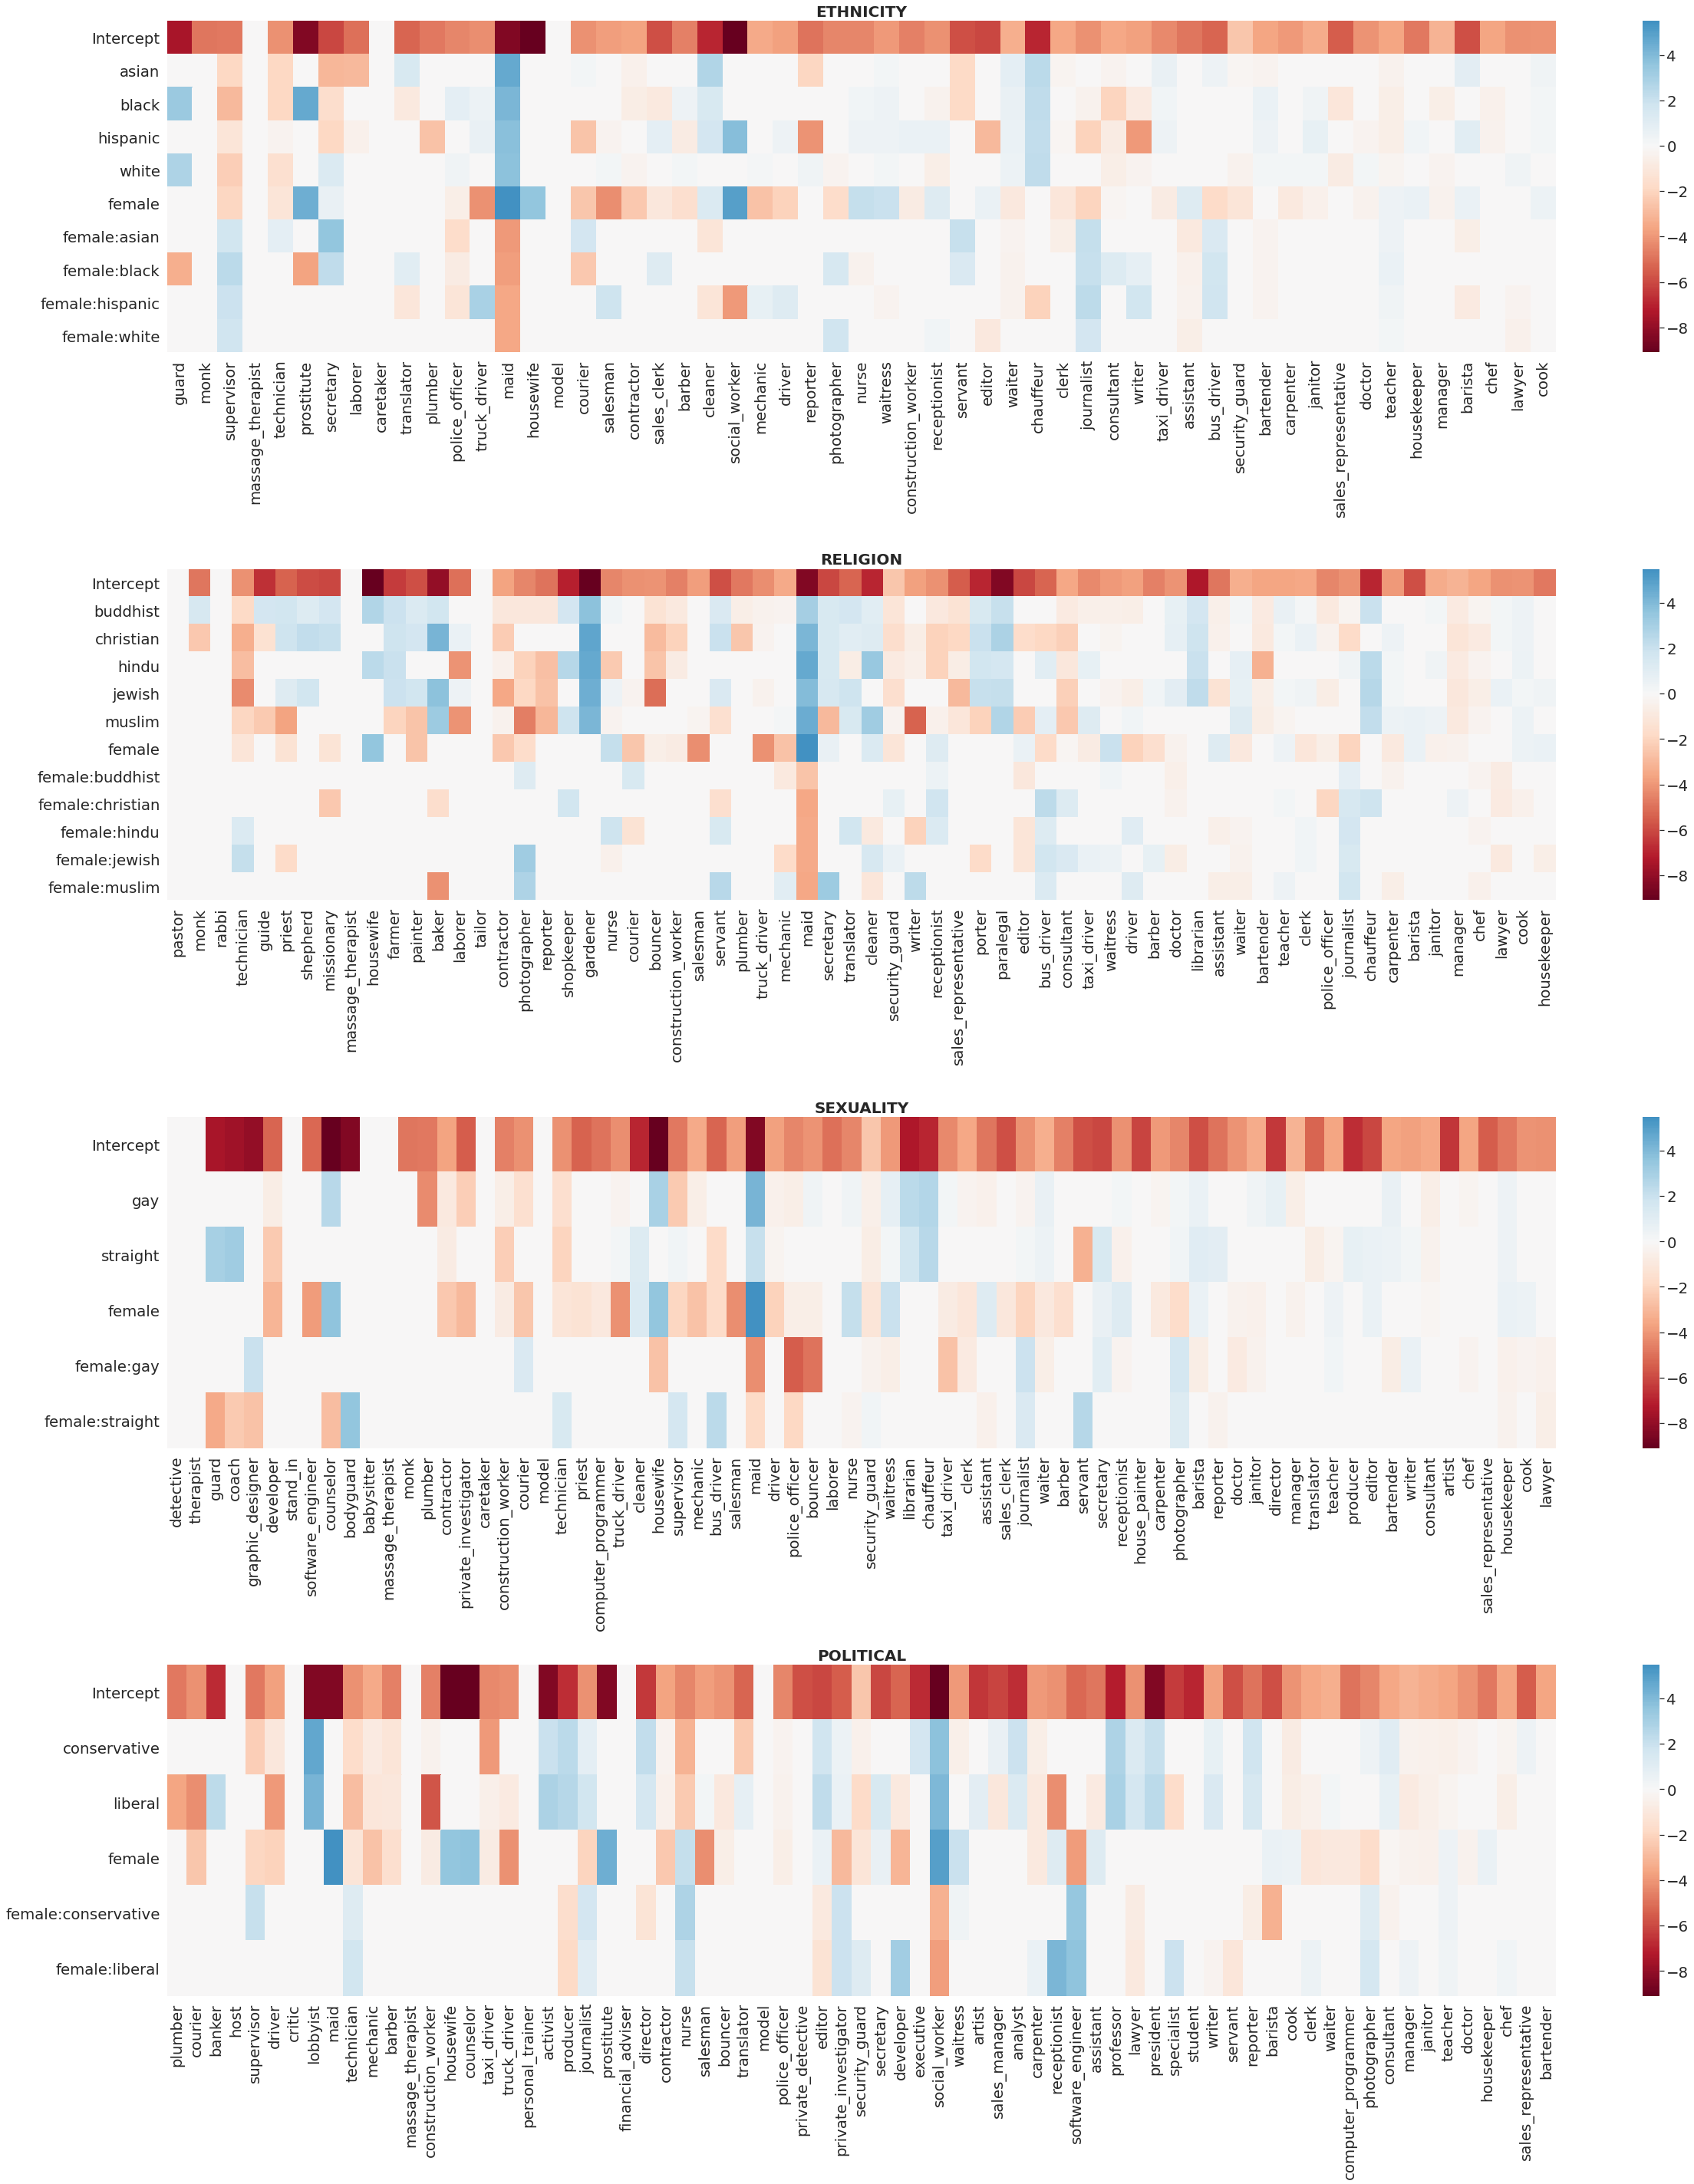

In [ ]:
make_heatmaps_coeffs()

In [ ]:
intersections = ['ethnicity', 'religion', 'sexuality', 'political']
def make_heatmaps_pvalues():
  ''' Function to create heatmap of significant p-values'''
  fig, axes = plt.subplots(nrows=4,ncols=1, figsize = (32,40))
  ax = axes.ravel()
  sns.set(font_scale=1.8)
  for i, intersection in enumerate(intersections):
    pvalue_df = pd.read_csv(f'./data/regressions/{intersection}_signif_pvalues.csv', index_col = 0) 
    pvalue_df.index = pvalue_df.index.str.replace('female', 'woman')
    sns.heatmap(pvalue_df, cmap = 'binary', cbar = False, ax = ax[i])
    ax[i].set_title(f'{intersection.upper()}', fontsize = 20, fontweight = 'bold')
    ax[i].tick_params(axis = 'x')
    ax[i].tick_params(axis = 'y',labelrotation = 0)
  plt.tight_layout()
  # fig.savefig(f'./figs/appendix_figs/pvalue_subplots.pdf', format='pdf', dpi=600, bbox_inches='tight')
  plt.show()

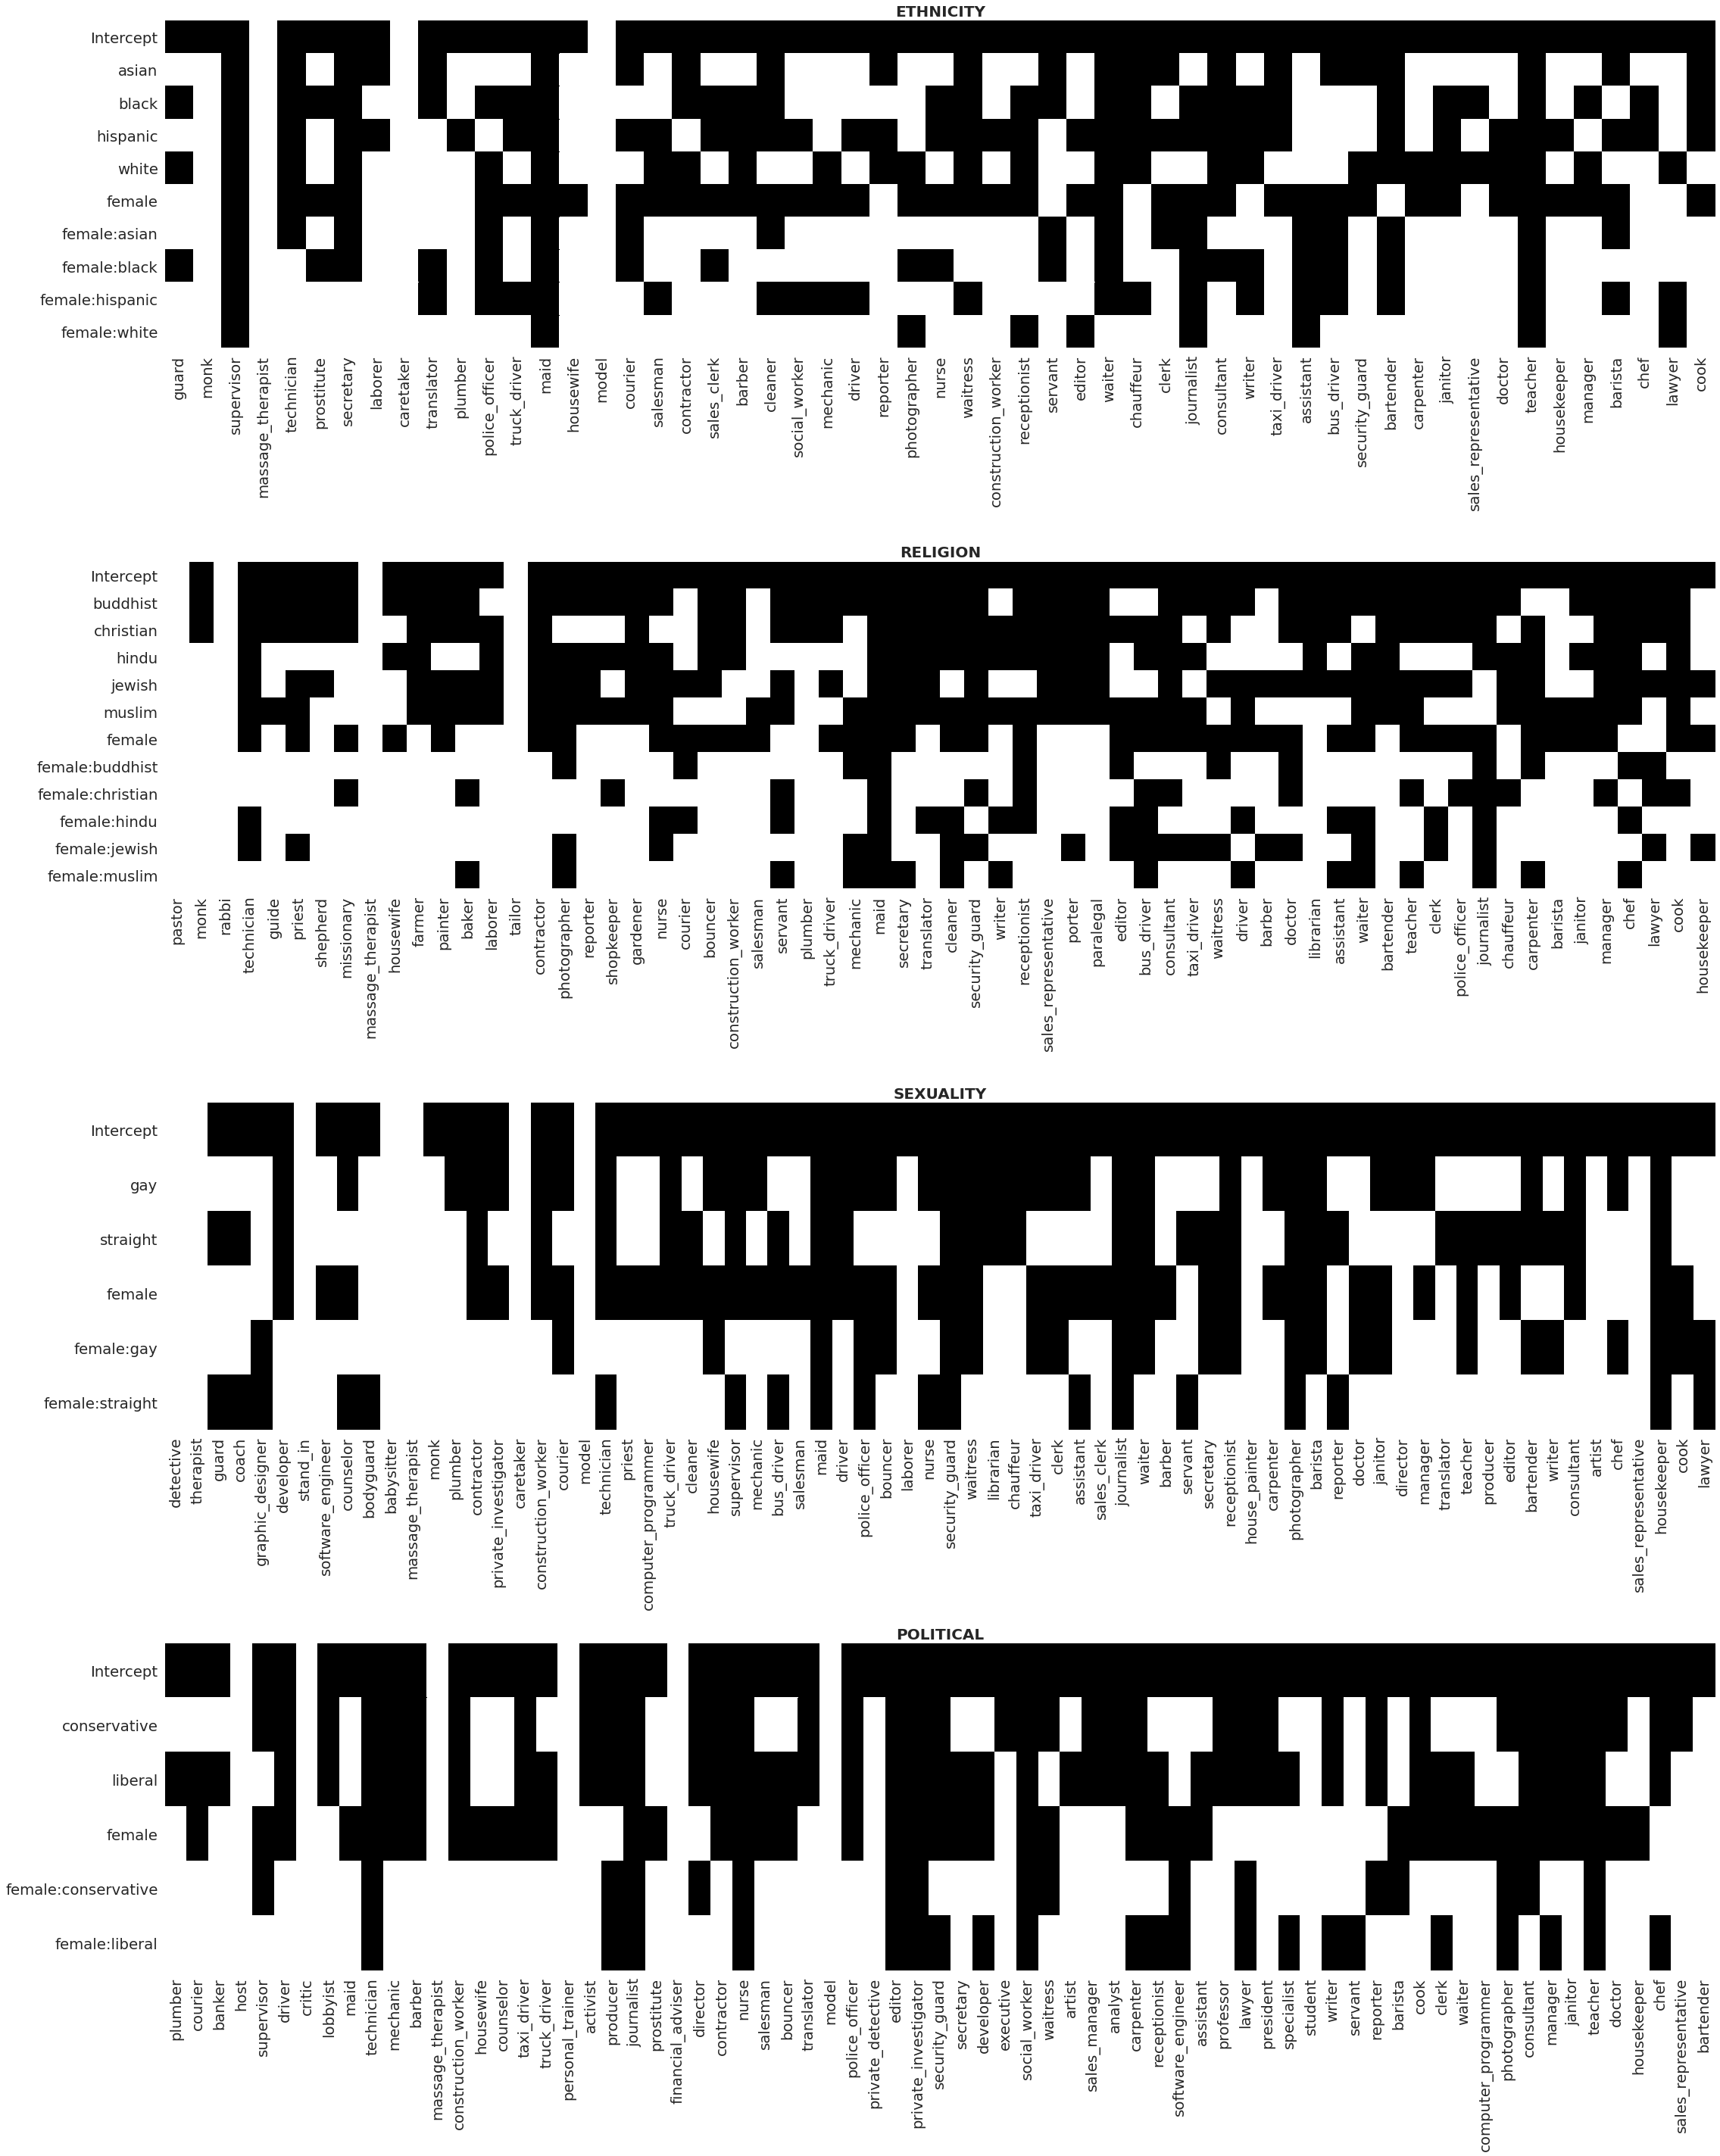

In [ ]:
make_heatmaps_pvalues()

In [ ]:
intersections = ['ethnicity', 'religion', 'sexuality', 'political']
def make_heatmaps_R2():
  ''' Function to create heatmap of changes to R2'''
  fig, axes = plt.subplots(nrows=4, figsize = (35, 40))
  ax = axes.ravel()
  sns.set(font_scale=1.8)
  for i, intersection in enumerate(intersections):
    R2_df = pd.read_csv(f'./data/regressions/{intersection}_R2.csv', index_col = 0) 
    R2_changes = R2_df.drop(['R2_gen', 'R2_main', 'R2_int'], axis=1)
    R2_changes = R2_changes.rename(columns = {'R2_gen_change': 'Add Woman Dummy', 'R2_int_change': 'Add Interactions'})
    sns.heatmap(R2_changes.T, cmap = 'Reds', cbar = True, ax = ax[i])
    ax[i].set_title(f'{intersection.upper()}', fontsize = 20, fontweight = 'bold')
    ax[i].tick_params(axis = 'y', labelrotation = 0)
  plt.tight_layout()
  # fig.savefig(f'./figs/appendix_figs/R2_subplots.pdf', format='pdf', dpi=600, bbox_inches='tight')
  plt.show()

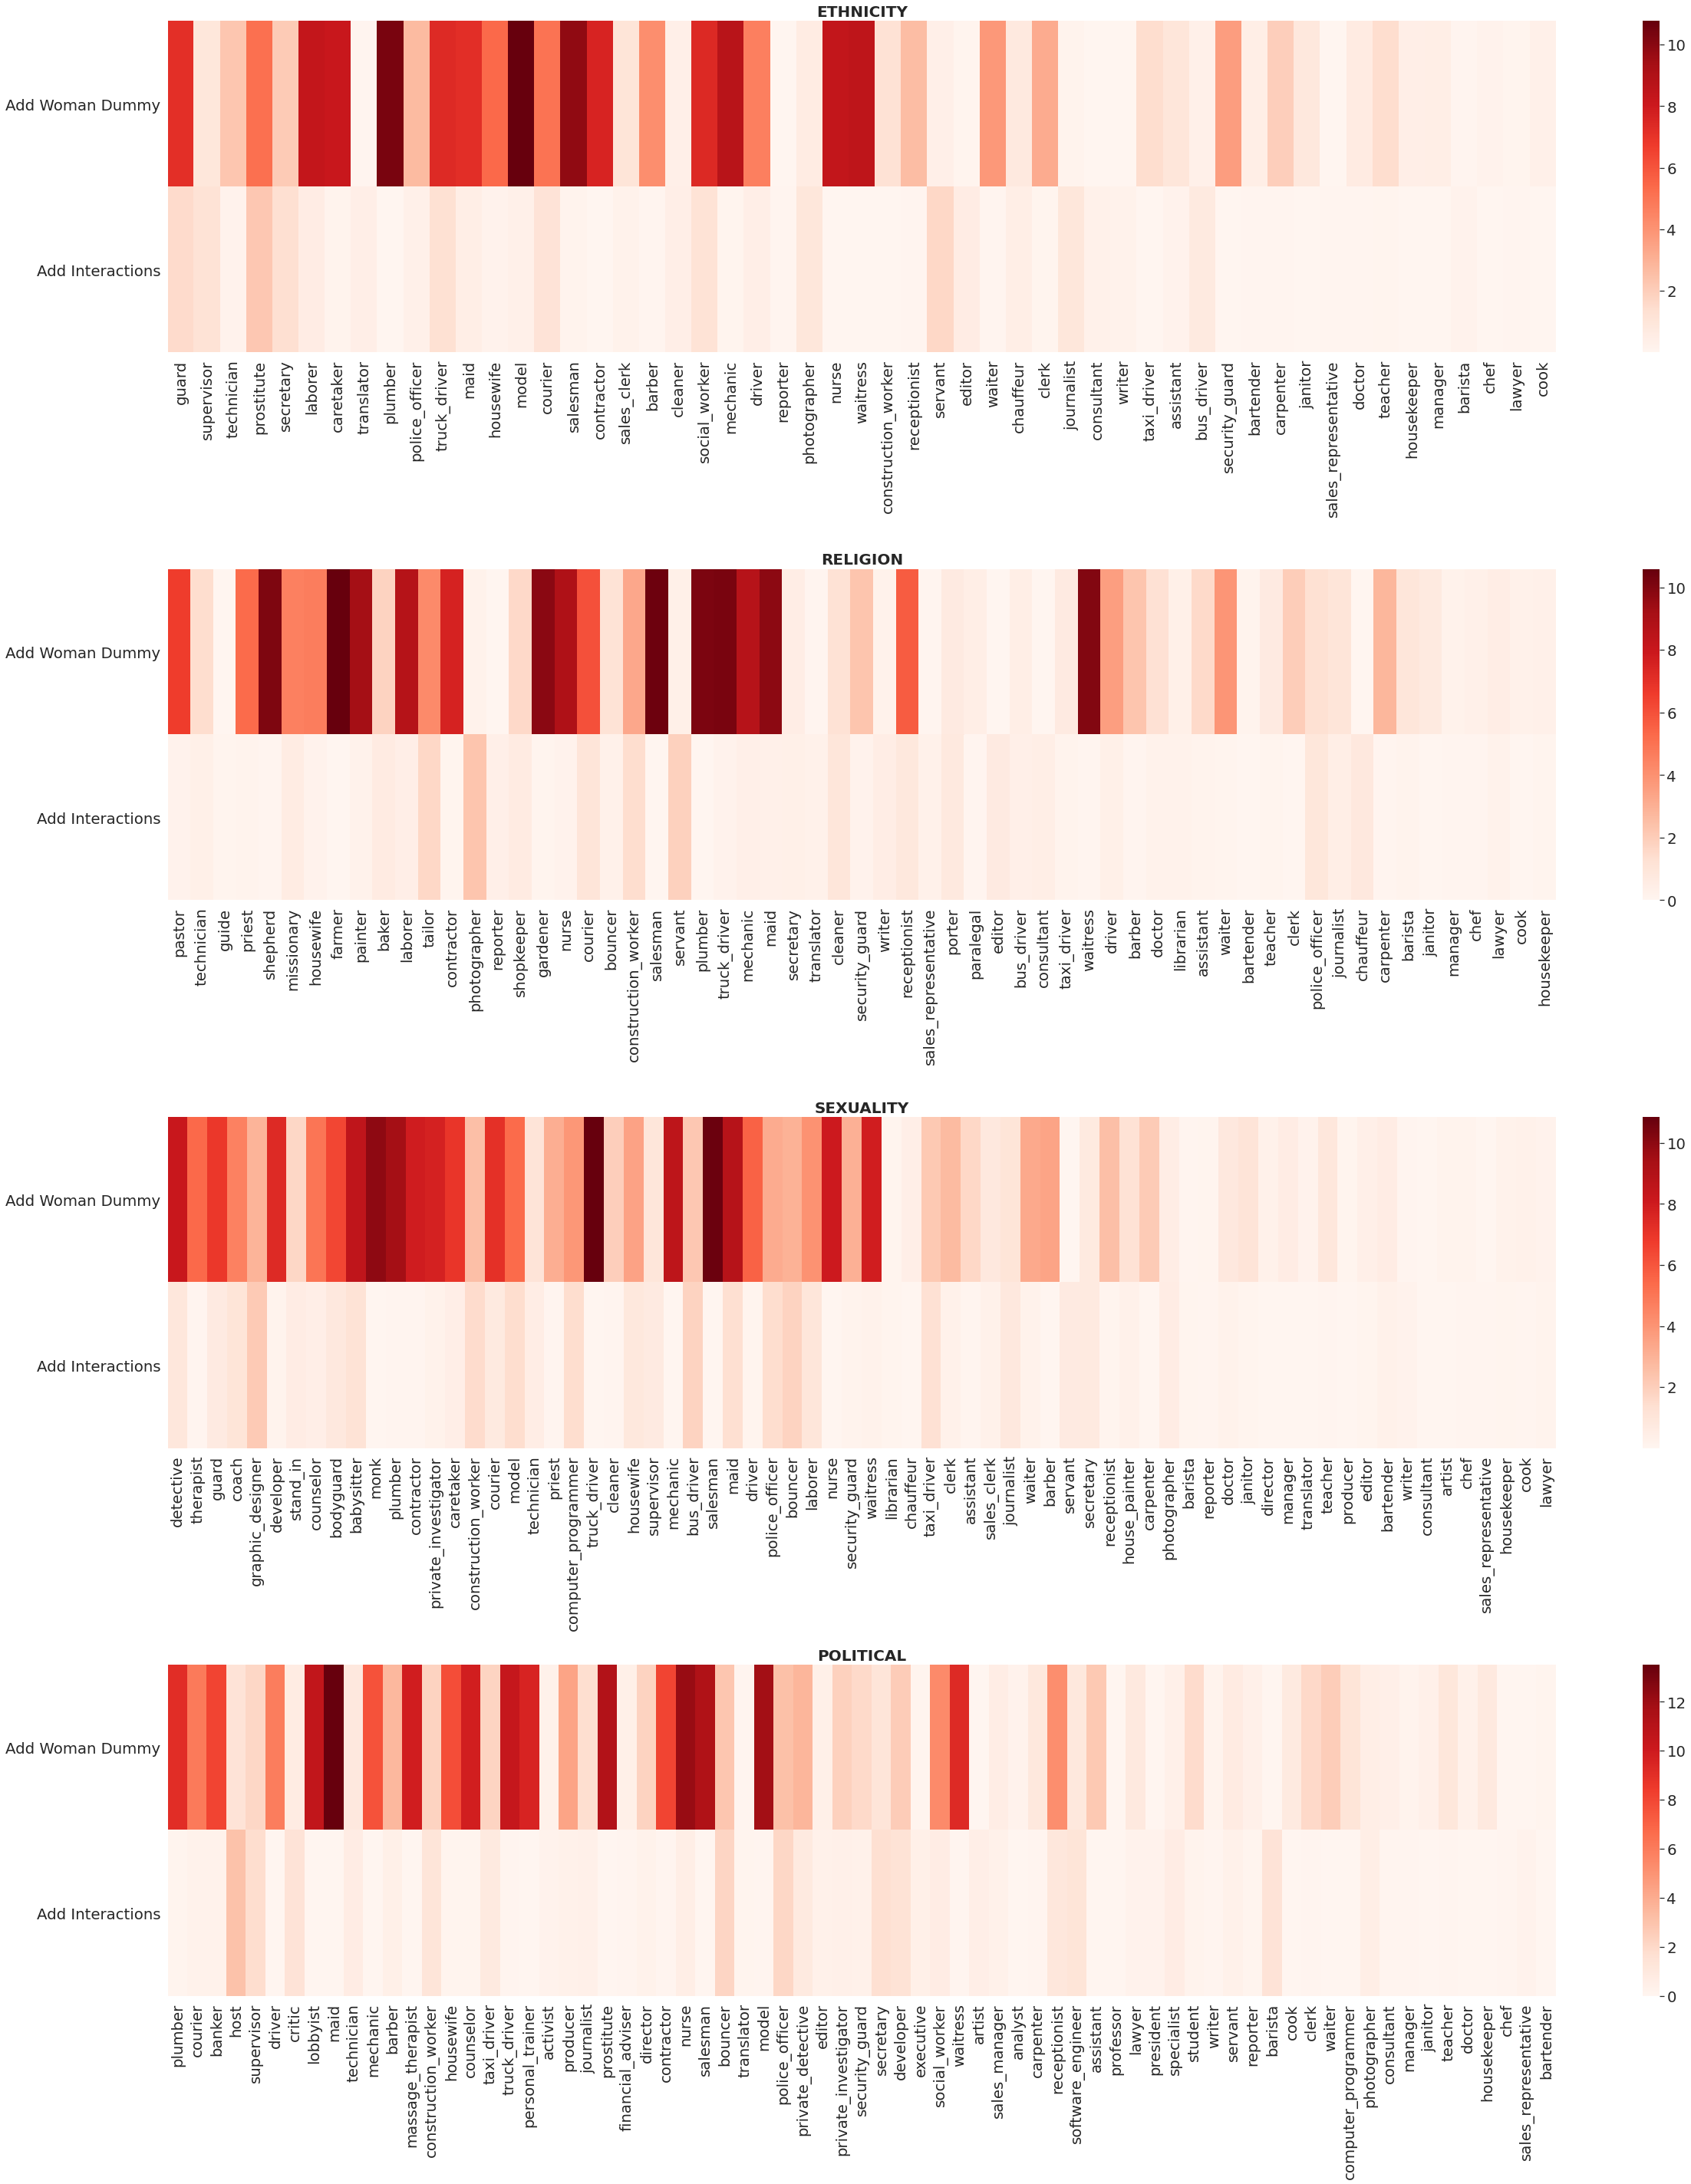

In [ ]:
make_heatmaps_R2()